<a href="https://colab.research.google.com/github/mcagriaksoy/Satellite_Images_Object_Detection_in_wide-deepLearning/blob/main/Wide%26DeepLearning_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi, welcome to my research of wide and deep learning :)

I would like to special thanks to my professeurs:

Beril Sirmacek b.sirmacek@saxion.nl
Cem Unsalan cem.unsalan@marmara.edu.tr



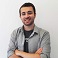

2021 - Created By Mehmet Çağrı Aksoy

https://orcid.org/0000-0002-7886-7945

https://www.researchgate.net/profile/Mehmet-Aksoy-12

https://github.com/mcagriaksoy

https://www.linkedin.com/in/mcagriaksoy/

https://scholar.google.com/citations?user=CKRkg1EAAAAJ&hl=en&oi=ao

# Dataset Preparetion 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/Thesis_Dataset/Ship.zip
!unzip /content/drive/MyDrive/Thesis_Dataset/Plane.zip

# Library Calls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# We'll build the CNN as a sequence of layers.
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
# Libraries to handle the data
import json
from PIL import Image # PIL = Python Image Library
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# Definitions

In [ ]:
batch_size = 64
epochs = 16 #number of times to pass over the training data to fit
# Ship Images are 80x80 pixels 
shippixel_width = 80
shippixel_height = 80
shipnumChannels = 3 # its 3D because it's RGB image data
# Plane Images are 20x20 pixels

# Result of Images are 32x32 pixels 
pixel_width = 32
pixel_height = 32
numChannels = 3 # its 3D because it's RGB image data

input_shape = (pixel_width, pixel_height, numChannels) 

# Data Gathering

In [ ]:
file = open('/content/planesnet.json')
dataset = json.load(file)
file.close()

images = []
for index in range( len( dataset['data'] )):
    pixel_vals = dataset['data'][index]
    arr = np.array(pixel_vals).astype('uint8')
    arr = arr / 255.0 # Need to scale this here as shipimages will be fractional after downsampling
    im = arr.reshape(( numChannels, 20 * 20)).T.reshape( (20, 20,numChannels)  )
    image_resized = resize(im, (pixel_width, pixel_height),mode='constant')
    images.append( image_resized )
           
file = open('/content/shipsnet.json')
shipdataset = json.load(file)
file.close()

shipinput_shape = (shippixel_width, shippixel_height,shipnumChannels) 

for index in range( len( shipdataset['data'] )):
    pixel_vals = shipdataset['data'][index]
    arr = np.array(pixel_vals).astype('uint8')
    im = arr.reshape((3, shippixel_width * shippixel_height)).T.reshape( shipinput_shape )
    image_resized = resize(im, (pixel_width, pixel_height),mode='constant')
    # this returns the image_resized in RGB format as (float,float,float)
    images.append( image_resized )
    
images = np.array( images )
labels = np.array(dataset['labels'])

shiplabels = 2* np.array(shipdataset['labels'])
labels = np.hstack( (labels, shiplabels))

# Data Preprocessing

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)

In [ ]:
from sklearn.model_selection import train_test_split
from skimage.exposure import adjust_gamma
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.20)

# Data Augmentation
#Generate new samples
#x_train1 = np.rot90(x_train,k=1,axes=(1,2))
'''
x_train2 = np.rot90(x_train,k=2,axes=(1,2))
x_train3 = np.rot90(x_train,k=3,axes=(1,2))
x_train4 = adjust_gamma(x_train, gamma=1.2,gain=1)
x_train5 = adjust_gamma(x_train, gamma=0.8,gain=1)
'''
#x_train = np.append(x_train,x_train1,axis=0)
'''
x_train = np.append(x_train,x_train2,axis=0)
x_train = np.append(x_train,x_train3,axis=0)
x_train = np.append(x_train,x_train4,axis=0)
x_train = np.append(x_train,x_train5,axis=0)
'''
#y_train = np.append(y_train,y_train)
'''
y_train3 = np.append(y_train,y_train2)
y_train4 = np.append(y_train,y_train3)
y_train = np.append(y_train,y_train4)
y_train = np.append(y_train,y_train5)
'''
#del x_train1
'''
del x_train2
del x_train3
del x_train4
del y_train2
del y_train3
del y_train4
'''

'\ndel x_train2\ndel x_train3\ndel x_train4\ndel y_train2\ndel y_train3\ndel y_train4\n'

In [ ]:
del images
del labels

Grab planes data, then append the ships data

In [ ]:
x_train.shape

(28800, 32, 32, 3)

In [ ]:
# We need to expand the labels to look like multiple-output nodes! 
# So if the category was 3, then the 3rd node would have a 1 in it!
y_train = tf.keras.utils.to_categorical( y_train, 3 )
y_test = tf.keras.utils.to_categorical( y_test, 3 )

# **Feature Extraction Steps for Wide Inputs**

---



## GLCM Features

In [ ]:
#GLCM Properties Definitions
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte

# GLCM properties
def contrast_feature(matrix_coocurrence):
	contrast = greycoprops(matrix_coocurrence, 'contrast')
	return contrast

def dissimilarity_feature(matrix_coocurrence):
	dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')	
	return dissimilarity

def homogeneity_feature(matrix_coocurrence):
	homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
	return homogeneity

def energy_feature(matrix_coocurrence):
	energy = greycoprops(matrix_coocurrence, 'energy')
	return energy

def correlation_feature(matrix_coocurrence):
	correlation = greycoprops(matrix_coocurrence, 'correlation')
	return correlation

def asm_feature(matrix_coocurrence):
	asm = greycoprops(matrix_coocurrence, 'ASM')
	return asm

bins32 = np.array([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160,
            168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 255]) #32-bit

In [ ]:
# Calculating the GLCM Properties !!

from skimage.feature import greycomatrix, greycoprops
from skimage import data
from skimage import util, exposure, data
import pywt
from skimage import io
from skimage.color import rgb2gray

lenx = x_train.shape[0]
X_homoTRAIN = np.zeros((lenx, 4))
X_correlationTRAIN = np.zeros((lenx, 4))
X_dissimilarityTRAIN = np.zeros((lenx, 4))
X_contrastTRAIN = np.zeros((lenx, 4))
X_energyTRAIN = np.zeros((lenx, 4))

for i in range(lenx):
    image32 = x_train[i]
    image32 = rgb2gray(image32)
    np.clip(image32, 0, 255, out=image32)
    image = image32.astype('uint8')
    inds = np.digitize(image, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_correlationTRAIN[i] = correlation_feature(matrix_coocurrence)
    X_homoTRAIN[i] = homogeneity_feature(matrix_coocurrence)
    X_contrastTRAIN[i] = contrast_feature(matrix_coocurrence)
    X_dissimilarityTRAIN[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTRAIN[i] = energy_feature(matrix_coocurrence)

len2 = x_test.shape[0]
X_homoTEST = np.zeros((len2, 4))
X_correlationTEST = np.zeros((len2, 4))
X_dissimilarityTEST = np.zeros((len2, 4))
X_contrastTEST = np.zeros((len2, 4))
X_energyTEST = np.zeros((len2, 4))

for i in range(len2):
    image32 = x_test[i]
    image32 = rgb2gray(image32)
    np.clip(image32, 0, 255, out=image32)
    image = image32.astype('uint8')
    inds = np.digitize(image, bins32)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    X_contrastTEST[i] = contrast_feature(matrix_coocurrence)
    X_correlationTEST[i] = correlation_feature(matrix_coocurrence)
    X_homoTEST[i] = homogeneity_feature(matrix_coocurrence)
    X_dissimilarityTEST[i] = dissimilarity_feature(matrix_coocurrence)
    X_energyTEST[i] = energy_feature(matrix_coocurrence)


In [ ]:
x_train_glcm = np.concatenate((X_correlationTRAIN, X_correlationTRAIN, X_homoTRAIN, X_dissimilarityTRAIN, X_energyTRAIN), axis=1)
x_test_glcm = np.concatenate((X_contrastTEST, X_correlationTEST, X_homoTEST, X_dissimilarityTEST, X_energyTEST), axis=1)

In [ ]:
x_train_glcm.shape

(28800, 20)

## Mean Value

In [ ]:
#Calculating mean values for wide inputs
from sklearn.preprocessing import normalize

x_train_mean = x_train.mean(axis=1).mean(axis=1)
x_test_mean = x_test.mean(axis=1).mean(axis=1)
x_train_mean = normalize(x_train_mean, axis=1, norm='l1')
x_test_mean = normalize(x_test_mean, axis=1, norm='l1')

In [ ]:
import cv2
#plt.imshow(image)

lenx = x_train.shape[0]
x_train_sobel_y = np.zeros((lenx, 32,32))
x_train_sobel_x = np.zeros((lenx, 32,32))


for i in range(lenx):
  image = rgb2gray(x_train[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_train_sobel_y[i] = grad_y
  x_train_sobel_x[i] = grad_x

x_test_sobel_y = np.zeros((lenx, 32,32))
x_test_sobel_x = np.zeros((lenx, 32,32))

lenx = x_test.shape[0]
for i in range(lenx):
  image = rgb2gray(x_test[i])
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
  x_test_sobel_y[i] = grad_y
  x_test_sobel_x[i] = grad_x


## Hu - Zernike Moments

In [ ]:
import cv2
def hu_moments(image):
    image = rgb2gray(image)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
lenx = x_train.shape[0]
x_train_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_train_HU[NUM] = hu_moments(x_train[NUM])

lenx = x_test.shape[0]
x_test_HU = np.zeros((lenx, 7))

for NUM in range(lenx):
  x_test_HU[NUM] = hu_moments(x_test[NUM])

In [ ]:
x_train_HU = normalize(x_train_HU, axis=1, norm='l1')
x_test_HU = normalize(x_test_HU, axis=1, norm='l1')

## Local Binary Patterns

In [ ]:
#https://github.com/arsho/local_binary_patterns

In [ ]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):  
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top 
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

In [ ]:
# Function to generate horizontal projection profile
def getHorizontalProjectionProfile(image):
    # Convert black spots to ones
    image[image == 0]   = 1
    # Convert white spots to zeros
    image[image == 255] = 0
    horizontal_projection = np.sum(image, axis = 1) 
    return horizontal_projection

# Function to generate vertical projection profile
def getVerticalProjectionProfile(image):
    # Convert black spots to ones 
    image[image == 0]   = 1
    # Convert white spots to zeros 
    image[image == 255] = 0
    vertical_projection = np.sum(image, axis = 0)
    return vertical_projection


In [ ]:
lenx = x_train.shape[0]
x_train_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_train[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_train_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)
    
lenx = x_test.shape[0]
x_test_lbp = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  gray = rgb2gray(x_test[NUM])
  for i in range(0, 32):
    for j in range(0, 32):
      x_test_lbp[NUM][i][j] = lbp_calculated_pixel(gray, i, j)

In [ ]:
from sklearn import preprocessing

lenx = x_train.shape[0]
x_train_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_lbp[NUM])
  x_train_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_lbp_vector[NUM] = normalize(x_train_lbp_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_lbp_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_lbp[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_lbp[NUM])
  x_test_lbp_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_lbp_vector[NUM] = normalize(x_test_lbp_vector[NUM].reshape(1, -1))

In [ ]:
x_train.shape

(28800, 32, 32, 3)

## Histogram of Oriented Gradients

In [ ]:

from skimage.feature import hog
from skimage import data, exposure

lenx = x_train.shape[0]
x_train_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_train_hog[NUM] = hog(x_train[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

lenx = x_test.shape[0]
x_test_hog = np.zeros((lenx, 32,32))

for NUM in range(lenx):
  fd, x_test_hog[NUM] = hog(x_test[NUM], orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1), visualize=True)

In [ ]:
x_train_hog.shape

(28800, 32, 32)

In [ ]:
lenx = x_train.shape[0]
x_train_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_train_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_train_hog[NUM])
  x_train_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_hog_vector[NUM] = normalize(x_train_hog_vector[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_hog_vector = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(x_test_hog[NUM])
  vertical_projection = getVerticalProjectionProfile(x_test_hog[NUM])
  x_test_hog_vector[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_hog_vector[NUM] = normalize(x_test_hog_vector[NUM].reshape(1, -1))

## Color Invariants (RGB)

In [ ]:
import PIL
import math

def invariant_r(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (r/max(g,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_g(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (g/max(r,b))
      c1[i][j]= math.atan(x)
  return c1

def invariant_b(img):
  c1 = np.zeros((32,32))
  for i in range(0, 32):
    for j in range(0, 32):
      b = img[i,j,0]
      g = img[i,j,1]
      r = img[i,j,2]
      x = (b/max(r,g))
      c1[i][j]= math.atan(x)
  return c1

In [ ]:
lenx = x_train.shape[0]
r_train = []
g_train = []
b_train = []

for NUM in range(lenx):
  r_train_tmp = invariant_r(x_train[NUM])
  g_train_tmp = invariant_g(x_train[NUM])
  b_train_tmp = invariant_b(x_train[NUM])

  r_train.append(r_train_tmp)
  g_train.append(g_train_tmp)
  b_train.append(b_train_tmp)

lenx = x_test.shape[0]
r_test = []
g_test = []
b_test = []

for NUM in range(lenx):
  r_test_tmp = invariant_r(x_test[NUM])
  g_test_tmp = invariant_g(x_test[NUM])
  b_test_tmp = invariant_b(x_test[NUM])

  r_test.append(r_test_tmp)
  g_test.append(g_test_tmp)
  b_test.append(b_test_tmp)


r_train = np.array(r_train)
g_train = np.array(g_train)
b_train = np.array(b_train)

r_test = np.array(r_test)
g_test = np.array(g_test)
b_test = np.array(b_test)


In [ ]:
lenx = x_train.shape[0]
x_train_invariant_Red = np.zeros((lenx, 64))
x_train_invariant_Green = np.zeros((lenx, 64))
x_train_invariant_Blue = np.zeros((lenx, 64))


for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_train[NUM])
  vertical_projection = getVerticalProjectionProfile(r_train[NUM])
  x_train_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Red[NUM] = normalize(x_train_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_train[NUM])
  vertical_projection = getVerticalProjectionProfile(g_train[NUM])
  x_train_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Green[NUM] = normalize(x_train_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_train[NUM])
  vertical_projection = getVerticalProjectionProfile(b_train[NUM])
  x_train_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_train_invariant_Blue[NUM] = normalize(x_train_invariant_Blue[NUM].reshape(1, -1))

lenx = x_test.shape[0]
x_test_invariant_Red = np.zeros((lenx, 64))
x_test_invariant_Green = np.zeros((lenx, 64))
x_test_invariant_Blue = np.zeros((lenx, 64))

for NUM in range(lenx):
  horizontal_projection = getHorizontalProjectionProfile(r_test[NUM])
  vertical_projection = getVerticalProjectionProfile(r_test[NUM])
  x_test_invariant_Red[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Red[NUM] = normalize(x_test_invariant_Red[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(g_test[NUM])
  vertical_projection = getVerticalProjectionProfile(g_test[NUM])
  x_test_invariant_Green[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Green[NUM] = normalize(x_test_invariant_Green[NUM].reshape(1, -1))

  horizontal_projection = getHorizontalProjectionProfile(b_test[NUM])
  vertical_projection = getVerticalProjectionProfile(b_test[NUM])
  x_test_invariant_Blue[NUM] = np.concatenate((horizontal_projection, vertical_projection), axis=0)
  x_test_invariant_Blue[NUM] = normalize(x_test_invariant_Blue[NUM].reshape(1, -1))

# **Custom Created Sequential CNN Experiments**



---



# CNN Tests:
16 Epochs:

  Wide And Deep:
*    512 Param Deep Input + 350 Param Wide Input  : .9923 Accuracy Max
*    384 Param Deep Input + 350 Param Wide Input  : .9934 Accuracy Max
*    256 Param Deep Input + 350 Param Wide Input  : .9934 Accuracy Max
*    128 Param Deep Input + 350 Param Wide Input  : .9907 Accuracy Max

Deep Only:
*     512 Param Deep Input: .9941 Accuracy Max



# **1st Model Experiments**

## Sequential Custom CNN Solution Only




In [ ]:
model = tf.keras.Sequential([
                              
    layers.Input(shape=input_shape),
    #layers.experimental.preprocessing.RandomFlip("horizontal"),
    #layers.experimental.preprocessing.RandomRotation(0.1),
    #layers.experimental.preprocessing.RandomContrast(0.25),
    #Conv Layer 1
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 2
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #Conv Layer 3
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    
    layers.Dense(units=3, activation='softmax')
])
# Choose the 'Adam' optimizer for Stochastic Gradient Descent
# https://arxiv.org/pdf/1609.04747.pdf
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_7 (Batc  (None, 13, 13, 128)      512       
 hNormalization)                                                 
                                                     

In [ ]:
history_cnn = model.fit( x_train,
                         y_train,
                         validation_data=(x_test,y_test),
                         epochs=epochs, 
                         batch_size = batch_size,
                         #callbacks = [reduce_lr]
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 25s 56ms/step - loss: 0.1559 - accuracy: 0.9410 - val_loss: 0.8299 - val_accuracy: 0.7856
Epoch 2/16
450/450 [==============================] - 34s 76ms/step - loss: 0.0908 - accuracy: 0.9665 - val_loss: 0.1407 - val_accuracy: 0.9419
Epoch 3/16
450/450 [==============================] - 38s 85ms/step - loss: 0.0679 - accuracy: 0.9753 - val_loss: 0.5424 - val_accuracy: 0.8471
Epoch 4/16
450/450 [==============================] - 22s 50ms/step - loss: 0.0521 - accuracy: 0.9811 - val_loss: 0.8730 - val_accuracy: 0.7797
Epoch 5/16
450/450 [==============================] - 20s 45ms/step - loss: 0.0413 - accuracy: 0.9852 - val_loss: 0.5950 - val_accuracy: 0.8447
Epoch 6/16
450/450 [==============================] - 20s 45ms/step - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.2353 - val_accuracy: 0.9300
Epoch 7/16
450/450 [==============================] - 20s 46ms/step - loss: 0.0338 - accuracy: 0.9888 - val_loss: 0.1623 - val_accuracy:

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

## Sequential Custom CNN Solution + Wide Inputs




### 512 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide512_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_109 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_109[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_24[0][0]']       
                                                                                                  
 batch_normalization_10 (BatchN  (None, 14, 14, 128)  512        ['conv2d_10[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_512 = wide512_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 39s 43ms/step - loss: 0.1868 - accuracy: 0.9251 - val_loss: 2.2336 - val_accuracy: 0.7653
Epoch 2/16
900/900 [==============================] - 39s 43ms/step - loss: 0.1171 - accuracy: 0.9560 - val_loss: 0.4059 - val_accuracy: 0.8117
Epoch 3/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0961 - accuracy: 0.9635 - val_loss: 0.4683 - val_accuracy: 0.8574
Epoch 4/16
900/900 [==============================] - 39s 44ms/step - loss: 0.0748 - accuracy: 0.9724 - val_loss: 1.1711 - val_accuracy: 0.7917
Epoch 5/16
900/900 [==============================] - 39s 44ms/step - loss: 0.0737 - accuracy: 0.9729 - val_loss: 0.1236 - val_accuracy: 0.9496
Epoch 6/16
900/900 [==============================] - 39s 44ms/step - loss: 0.0571 - accuracy: 0.9788 - val_loss: 1.0257 - val_accuracy: 0.8033
Epoch 7/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0517 - accuracy: 0.9805 - val_loss: 0.1722 - val_accuracy:

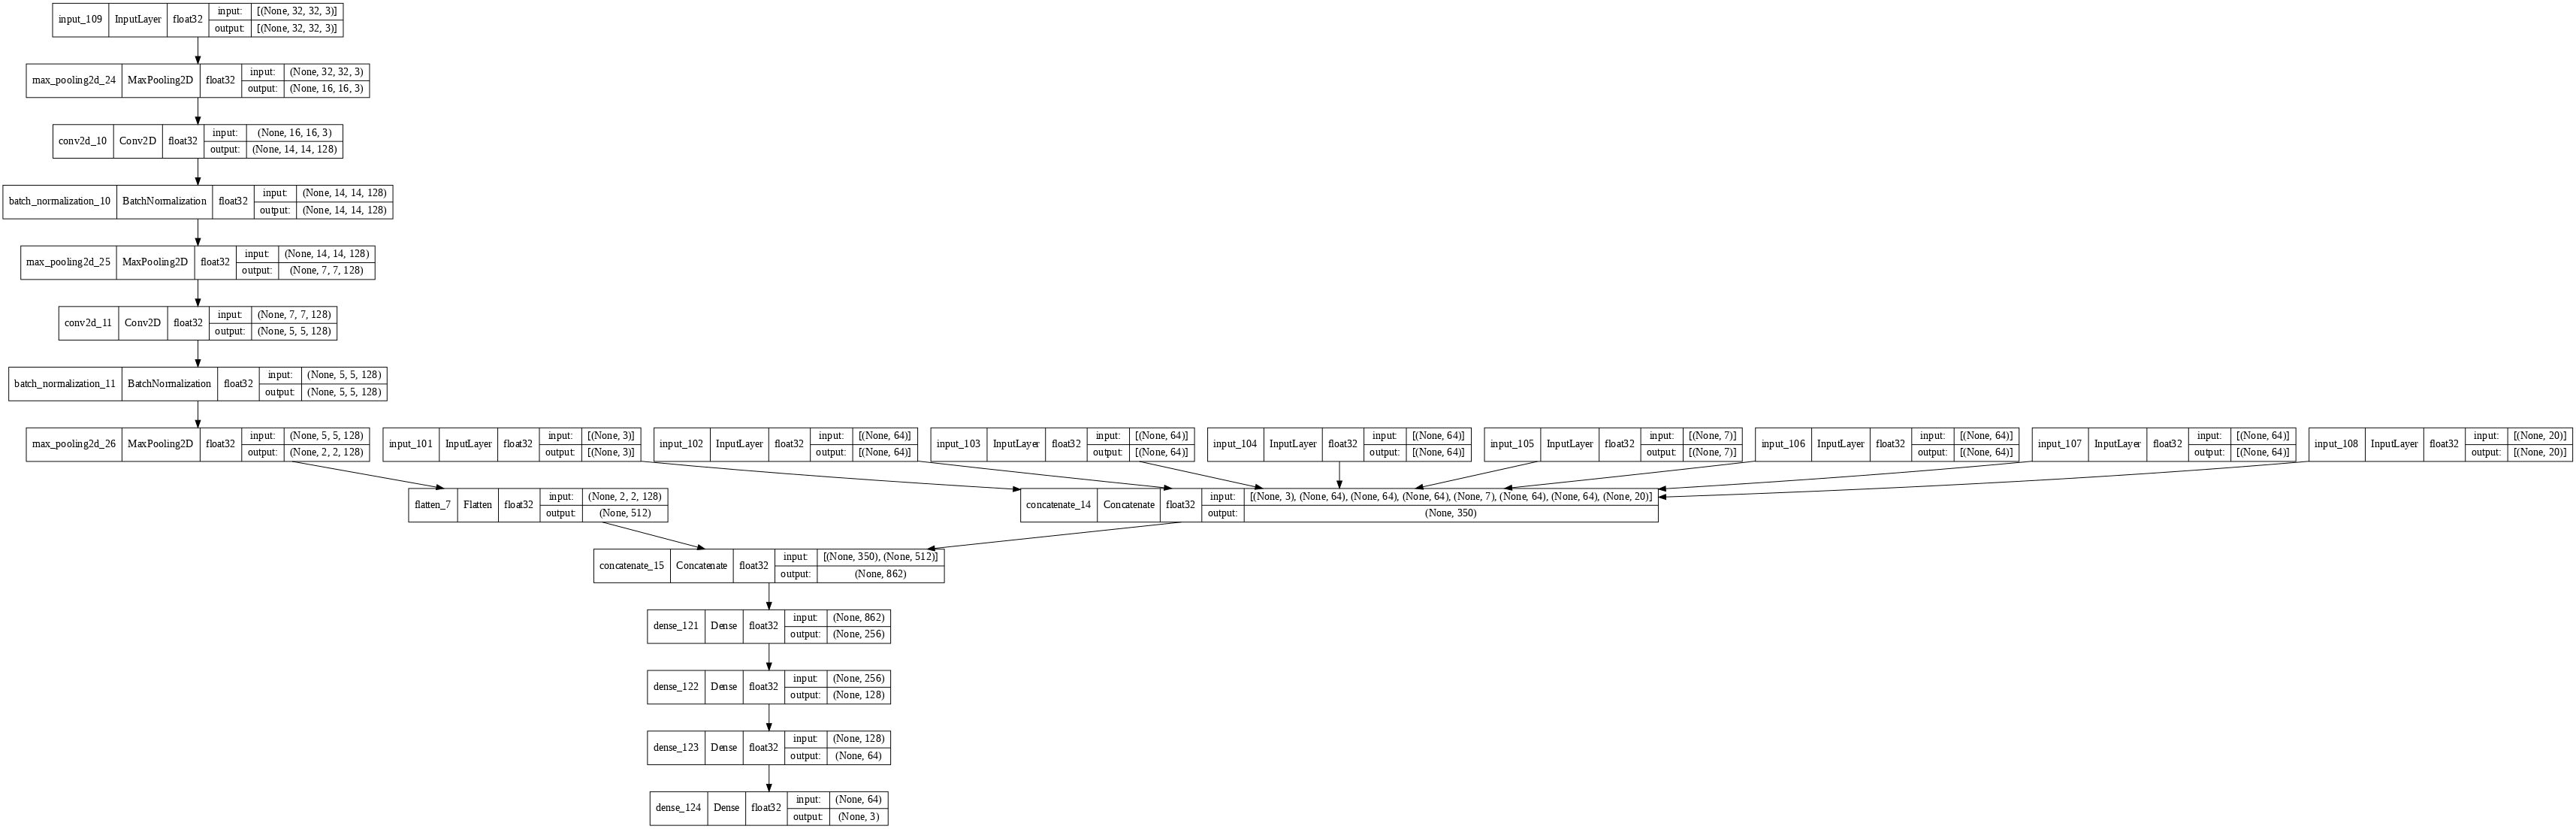

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

### 384 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide384_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=384, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide384_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide384_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide384_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_127 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_30 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_127[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_30[0][0]']       
                                                                                                  
 batch_normalization_16 (BatchN  (None, 14, 14, 128)  512        ['conv2d_16[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_384 = wide384_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 75s 83ms/step - loss: 0.1925 - accuracy: 0.9253 - val_loss: 1.1409 - val_accuracy: 0.7803
Epoch 2/16
900/900 [==============================] - 44s 48ms/step - loss: 0.1186 - accuracy: 0.9547 - val_loss: 0.7225 - val_accuracy: 0.8144
Epoch 3/16
900/900 [==============================] - 41s 45ms/step - loss: 0.0913 - accuracy: 0.9668 - val_loss: 0.1948 - val_accuracy: 0.9357
Epoch 4/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0791 - accuracy: 0.9705 - val_loss: 0.3923 - val_accuracy: 0.8679
Epoch 5/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0622 - accuracy: 0.9776 - val_loss: 1.0916 - val_accuracy: 0.7990
Epoch 6/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0603 - accuracy: 0.9776 - val_loss: 0.0821 - val_accuracy: 0.9688
Epoch 7/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0467 - accuracy: 0.9835 - val_loss: 0.2785 - val_accuracy:

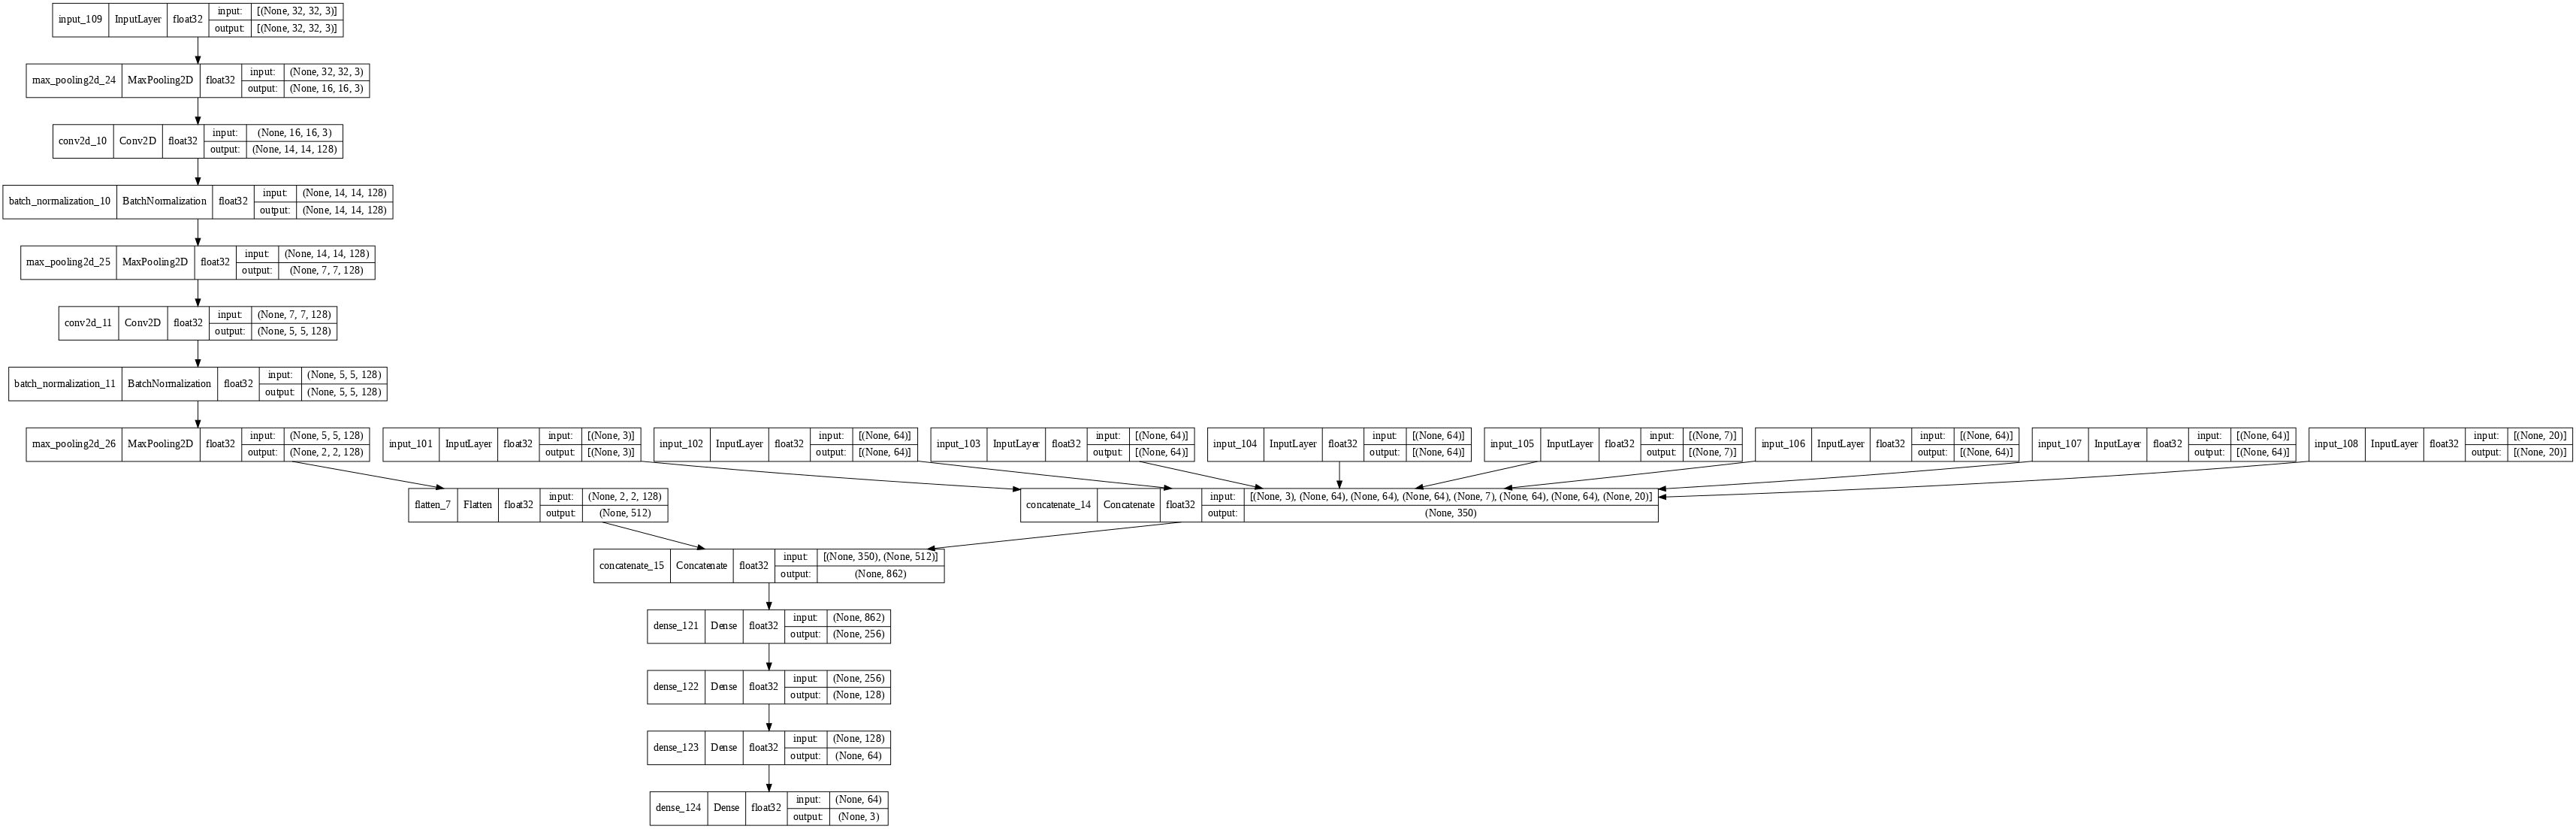

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

###256 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=256, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection

merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide256_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_145 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_145[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_36[0][0]']       
                                                                                                  
 batch_normalization_22 (BatchN  (None, 14, 14, 128)  512        ['conv2d_22[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_256 = wide256_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 38s 42ms/step - loss: 0.1914 - accuracy: 0.9244 - val_loss: 0.1986 - val_accuracy: 0.9157
Epoch 2/16
900/900 [==============================] - 37s 42ms/step - loss: 0.1166 - accuracy: 0.9555 - val_loss: 0.4637 - val_accuracy: 0.8522
Epoch 3/16
900/900 [==============================] - 37s 42ms/step - loss: 0.0916 - accuracy: 0.9671 - val_loss: 0.5301 - val_accuracy: 0.8074
Epoch 4/16
900/900 [==============================] - 37s 42ms/step - loss: 0.0757 - accuracy: 0.9723 - val_loss: 0.1046 - val_accuracy: 0.9635
Epoch 5/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.9066 - val_accuracy: 0.8224
Epoch 6/16
900/900 [==============================] - 38s 43ms/step - loss: 0.0525 - accuracy: 0.9805 - val_loss: 0.1171 - val_accuracy: 0.9576
Epoch 7/16
900/900 [==============================] - 37s 42ms/step - loss: 0.0467 - accuracy: 0.9841 - val_loss: 4.1392 - val_accuracy:

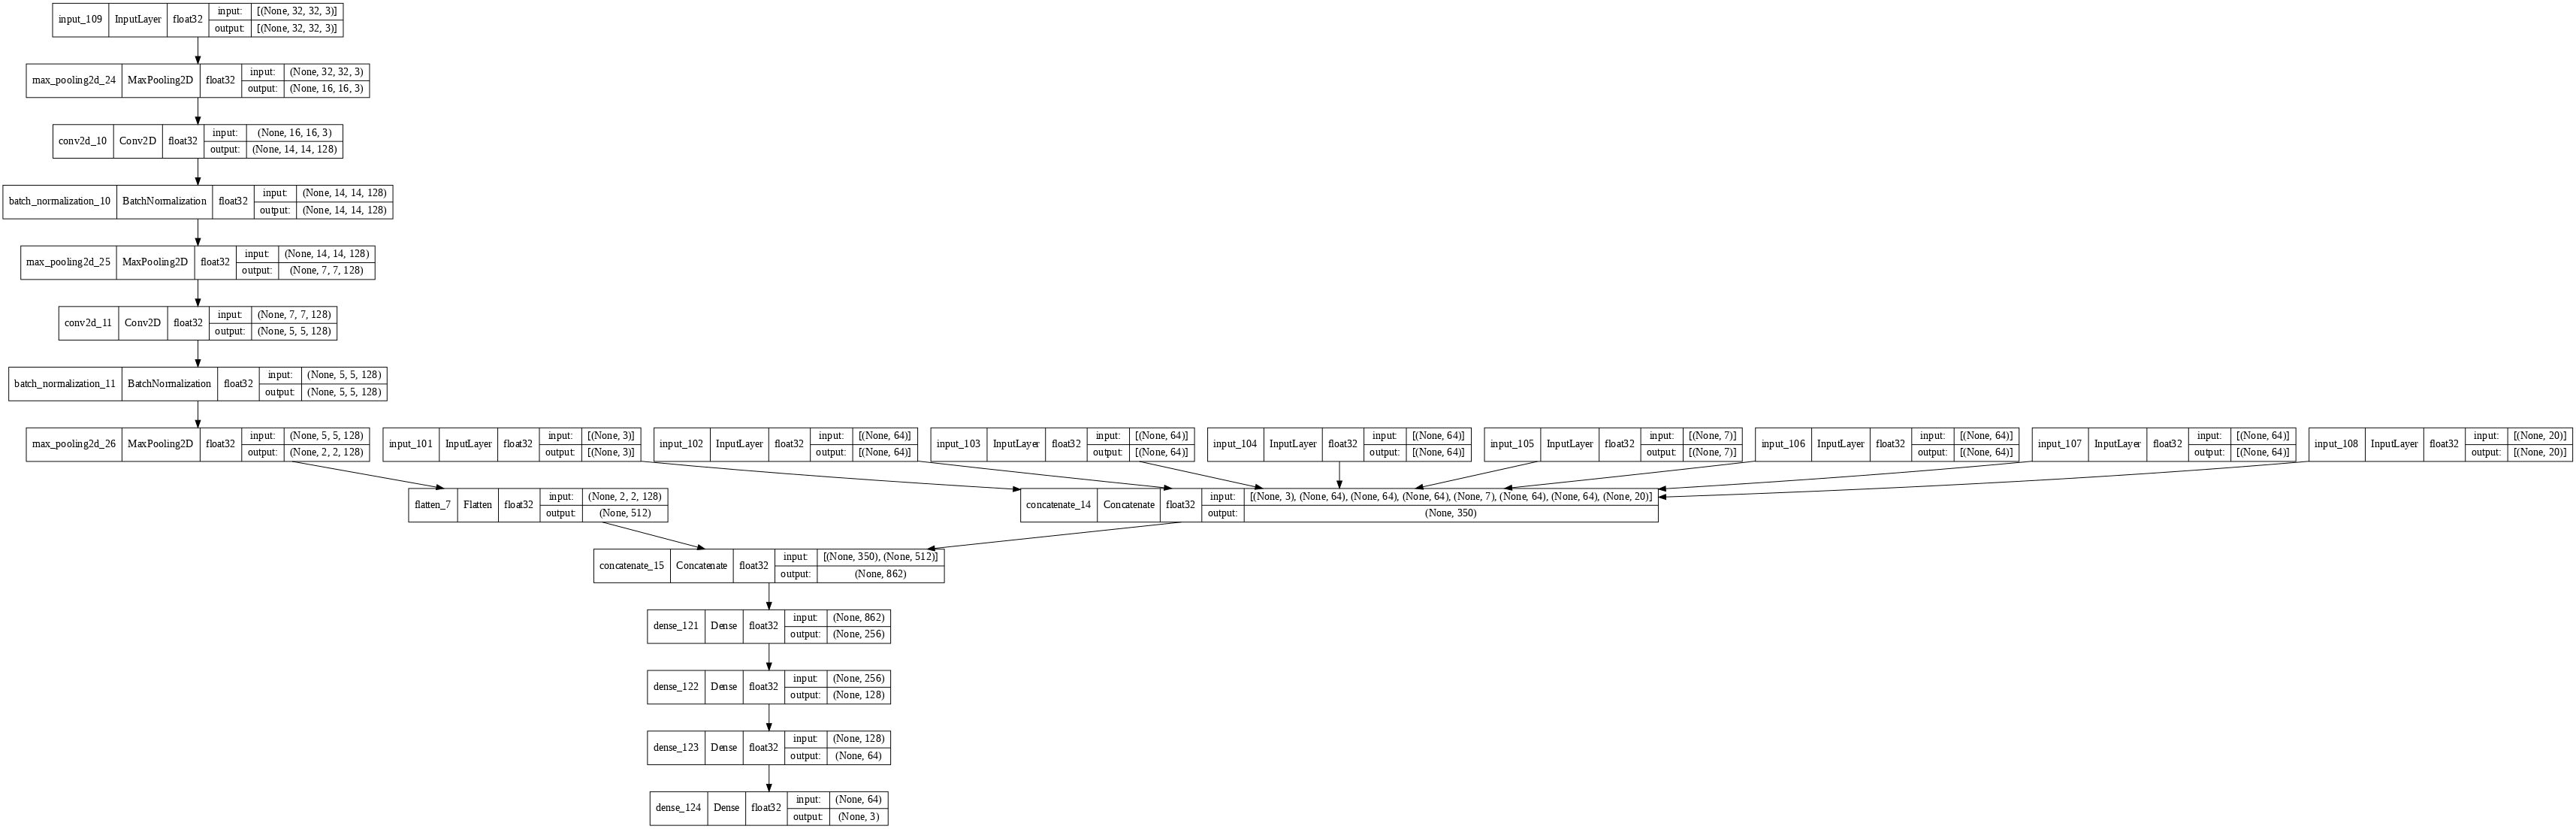

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

###128 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.1)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.25)(aug)

#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=256, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide128_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide128_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_136 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_136[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 14, 14, 128)  3584        ['max_pooling2d_33[0][0]']       
                                                                                                  
 batch_normalization_19 (BatchN  (None, 14, 14, 128)  512        ['conv2d_19[0][0]']       

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_128 = wide128_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 38s 42ms/step - loss: 0.1844 - accuracy: 0.9270 - val_loss: 1.2646 - val_accuracy: 0.7808
Epoch 2/16
900/900 [==============================] - 38s 42ms/step - loss: 0.1165 - accuracy: 0.9565 - val_loss: 0.1729 - val_accuracy: 0.9232
Epoch 3/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0923 - accuracy: 0.9658 - val_loss: 0.4020 - val_accuracy: 0.8929
Epoch 4/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0805 - accuracy: 0.9711 - val_loss: 0.1000 - val_accuracy: 0.9650
Epoch 5/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0624 - accuracy: 0.9784 - val_loss: 0.1573 - val_accuracy: 0.9397
Epoch 6/16
900/900 [==============================] - 37s 42ms/step - loss: 0.0596 - accuracy: 0.9782 - val_loss: 0.1200 - val_accuracy: 0.9553
Epoch 7/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0575 - accuracy: 0.9793 - val_loss: 0.8325 - val_accuracy:

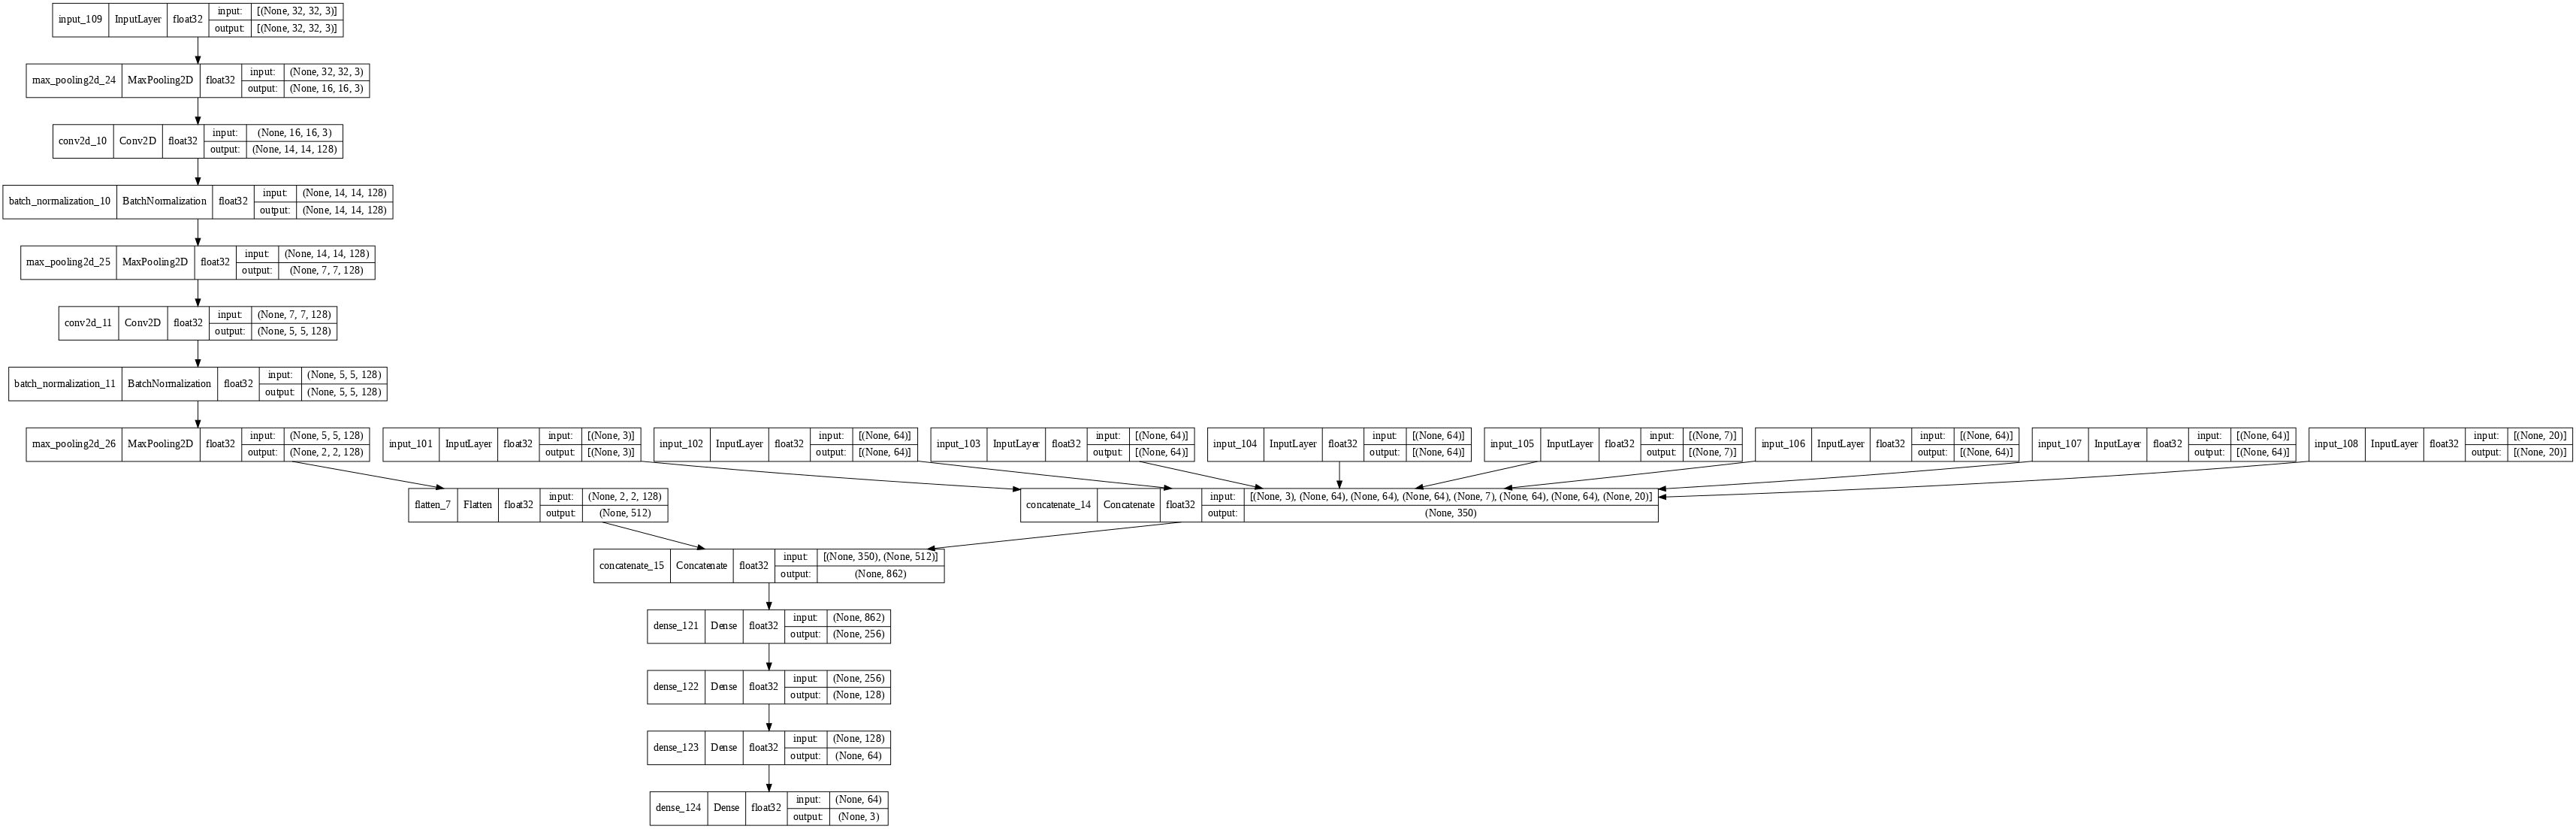

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

### RESULTS Comparisons

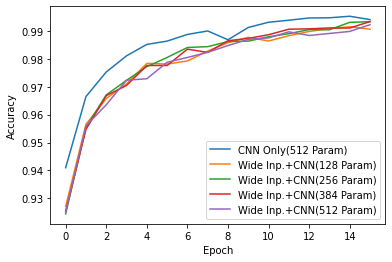

In [ ]:
#plt.plot(history_cnn.history['accuracy'])
plt.plot(history_128.history['accuracy'])
plt.plot(history_256.history['accuracy'])
plt.plot(history_384.history['accuracy'])
plt.plot(history_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Wide Inp.+CNN(128 Param)', 'Wide Inp.+CNN(256 Param)' , 'Wide Inp.+CNN(384 Param)', 'Wide Inp.+CNN(512 Param)'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

In [ ]:

from matplotlib.pyplot import figure
plt.figure(figsize=(18, 10), dpi=65)
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN')

plt.plot(CORRhistory.history['accuracy'],label='>GLCM(Correlation) Only< Wide-CNN')
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN') 
plt.plot(history_mean_only.history['accuracy'],label='>Mean Value Only< Wide-CNN')
plt.plot(history_cnn.history['accuracy'],label='Deep Learning-CNN Only')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()



In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)
print(classification_report(y_test, y_pred))

# **2nd Model Experiments**

## Sequential Custom CNN Solution + Wide Inputs




### 256 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_256 = wide512_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 80s 89ms/step - loss: 0.1750 - accuracy: 0.9320 - val_loss: 0.6441 - val_accuracy: 0.8075
Epoch 2/16
900/900 [==============================] - 69s 77ms/step - loss: 0.1268 - accuracy: 0.9512 - val_loss: 0.1525 - val_accuracy: 0.9436
Epoch 3/16
900/900 [==============================] - 46s 51ms/step - loss: 0.1054 - accuracy: 0.9590 - val_loss: 0.1491 - val_accuracy: 0.9399
Epoch 4/16
900/900 [==============================] - 43s 47ms/step - loss: 0.0833 - accuracy: 0.9691 - val_loss: 0.1187 - val_accuracy: 0.9536
Epoch 5/16
900/900 [==============================] - 42s 47ms/step - loss: 0.0735 - accuracy: 0.9730 - val_loss: 0.0959 - val_accuracy: 0.9624
Epoch 6/16
900/900 [==============================] - 42s 46ms/step - loss: 0.0610 - accuracy: 0.9774 - val_loss: 0.1115 - val_accuracy: 0.9543
Epoch 7/16
900/900 [==============================] - 42s 46ms/step - loss: 0.0571 - accuracy: 0.9787 - val_loss: 1.5339 - val_accuracy:

### 512 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)

# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection

merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide512_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide512_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_45[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 14, 14, 64)   1792        ['max_pooling2d_12[0][0]']       
                                                                                                  
 batch_normalization_13 (BatchN  (None, 14, 14, 64)  256         ['conv2d_13[0][0]']        

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_512 = wide512_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 66s 73ms/step - loss: 0.1869 - accuracy: 0.9241 - val_loss: 0.1759 - val_accuracy: 0.9324
Epoch 2/16
900/900 [==============================] - 42s 47ms/step - loss: 0.1168 - accuracy: 0.9562 - val_loss: 0.1576 - val_accuracy: 0.9362
Epoch 3/16
900/900 [==============================] - 43s 48ms/step - loss: 0.1017 - accuracy: 0.9621 - val_loss: 0.6160 - val_accuracy: 0.8399
Epoch 4/16
900/900 [==============================] - 44s 49ms/step - loss: 0.0838 - accuracy: 0.9693 - val_loss: 0.7729 - val_accuracy: 0.8014
Epoch 5/16
900/900 [==============================] - 44s 48ms/step - loss: 0.0762 - accuracy: 0.9707 - val_loss: 0.0958 - val_accuracy: 0.9638
Epoch 6/16
900/900 [==============================] - 43s 48ms/step - loss: 0.0582 - accuracy: 0.9789 - val_loss: 0.6055 - val_accuracy: 0.8587
Epoch 7/16
900/900 [==============================] - 42s 47ms/step - loss: 0.0484 - accuracy: 0.9815 - val_loss: 0.0708 - val_accuracy:

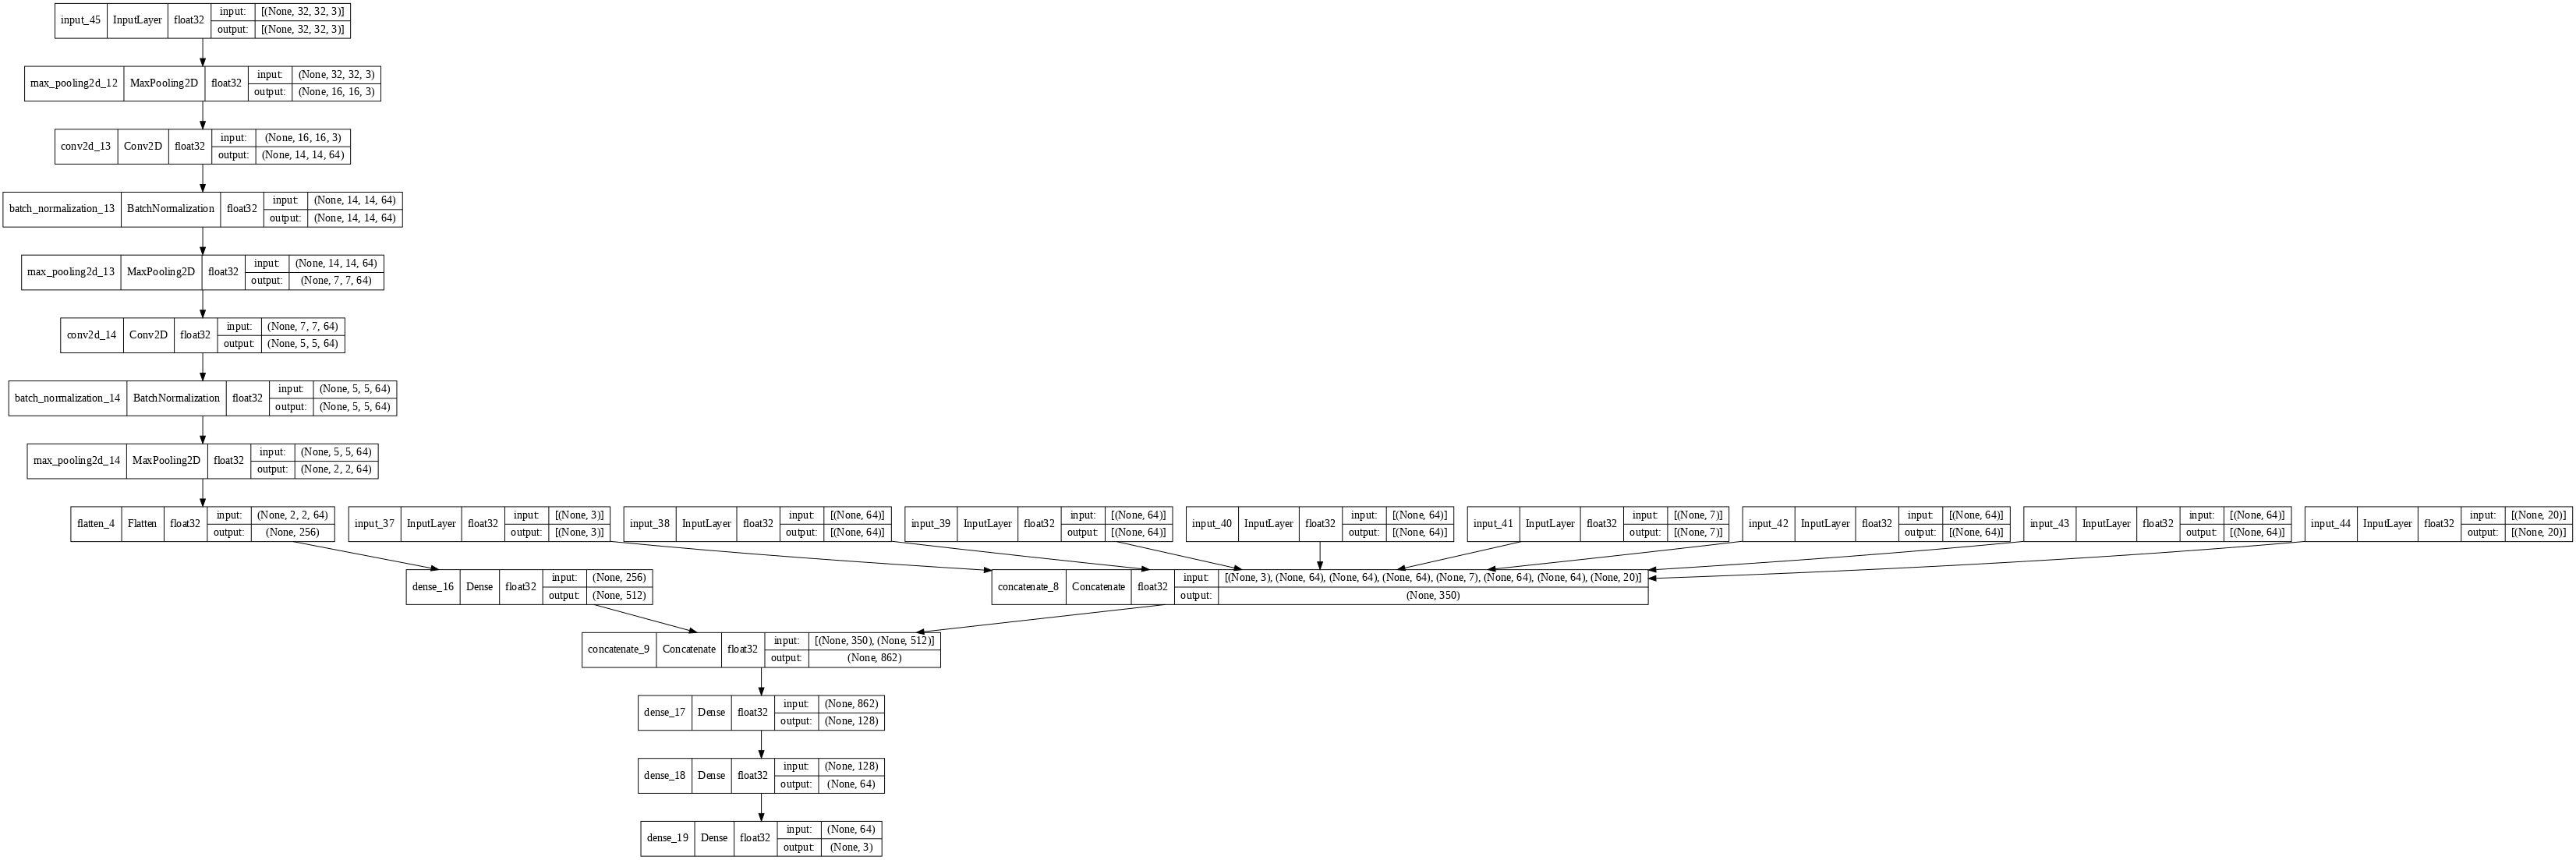

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

###128 Deep Input + 350 Wide Input

In [ ]:
layers = tf.keras.layers

wide128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
#Conv Layer 3
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
mergedwide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM,
                                              ])
merged_out = layers.Concatenate(axis=1)([mergedwide, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide128_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ], 
                             outputs=merged_out)

wide128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide128_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_54[0][0]']               
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 64)   1792        ['max_pooling2d_15[0][0]']       
                                                                                                  
 batch_normalization_16 (BatchN  (None, 14, 14, 64)  256         ['conv2d_16[0][0]']        

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_128 = wide128_model.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 41s 46ms/step - loss: 0.1714 - accuracy: 0.9322 - val_loss: 1.6435 - val_accuracy: 0.7608
Epoch 2/16
900/900 [==============================] - 41s 45ms/step - loss: 0.1077 - accuracy: 0.9596 - val_loss: 1.6145 - val_accuracy: 0.7792
Epoch 3/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0901 - accuracy: 0.9664 - val_loss: 0.1927 - val_accuracy: 0.9111
Epoch 4/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0753 - accuracy: 0.9720 - val_loss: 0.1172 - val_accuracy: 0.9557
Epoch 5/16
900/900 [==============================] - 41s 46ms/step - loss: 0.0619 - accuracy: 0.9763 - val_loss: 0.0950 - val_accuracy: 0.9657
Epoch 6/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0575 - accuracy: 0.9783 - val_loss: 0.1564 - val_accuracy: 0.9433
Epoch 7/16
900/900 [==============================] - 40s 45ms/step - loss: 0.0498 - accuracy: 0.9820 - val_loss: 0.0943 - val_accuracy:

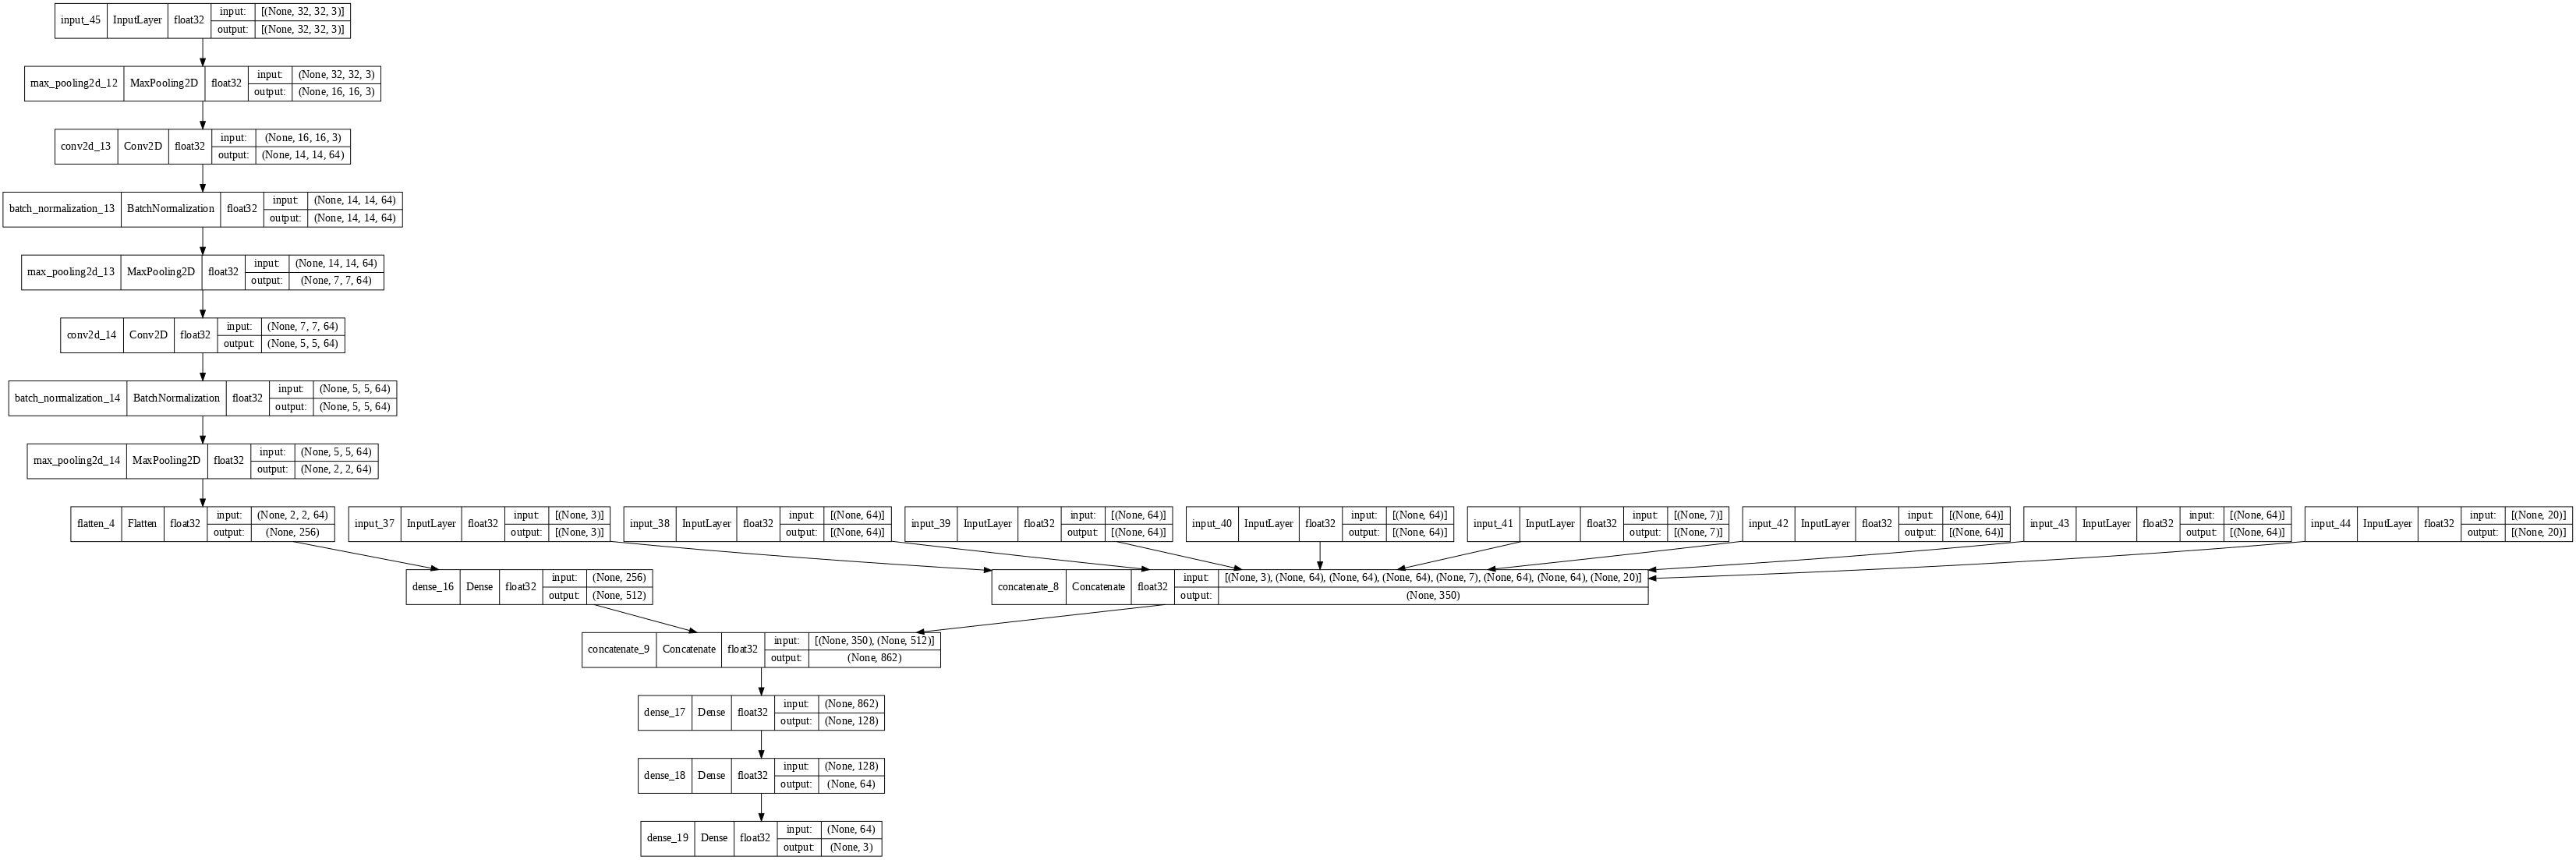

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide512_model, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

### RESULTS Comparisons

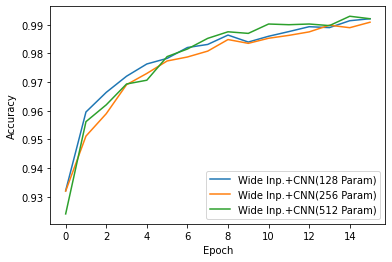

In [ ]:
#plt.plot(history_cnn.history['accuracy'])
plt.plot(history_128.history['accuracy'])
plt.plot(history_256.history['accuracy'])
plt.plot(history_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Wide Inp.+CNN(128 Param)', 'Wide Inp.+CNN(256 Param)' , 'Wide Inp.+CNN(512 Param)'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

In [ ]:

from matplotlib.pyplot import figure
plt.figure(figsize=(18, 10), dpi=65)
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN')

plt.plot(CORRhistory.history['accuracy'],label='>GLCM(Correlation) Only< Wide-CNN')
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN') 
plt.plot(history_mean_only.history['accuracy'],label='>Mean Value Only< Wide-CNN')
plt.plot(history_cnn.history['accuracy'],label='Deep Learning-CNN Only')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()



In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)
print(classification_report(y_test, y_pred))

# **3rd Model Experiments**



## Sequential Custom CNN Solution Only ( Model Experiment - 2 )




In [ ]:
model = tf.keras.Sequential([
                              
    layers.Input(shape=input_shape),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomContrast(0.2),
    #Conv Layer 1
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    #Conv Layer 2
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    #Conv Layer 3
    layers.Conv2D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=3, activation='softmax')
])
# Choose the 'Adam' optimizer for Stochastic Gradient Descent
# https://arxiv.org/pdf/1609.04747.pdf
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 32, 32, 3)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 64)       256       
 ormalization)                                                   
                                                      

In [ ]:
history_cnn_exp2 = model.fit( x_train,
                         y_train,
                         validation_data=(x_test,y_test),
                         epochs=epochs, 
                         #callbacks = [reduce_lr]
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 65s 72ms/step - loss: 0.2818 - accuracy: 0.8887 - val_loss: 0.2824 - val_accuracy: 0.8789
Epoch 2/16
900/900 [==============================] - 65s 72ms/step - loss: 0.1762 - accuracy: 0.9341 - val_loss: 0.4125 - val_accuracy: 0.8518
Epoch 3/16
900/900 [==============================] - 64s 71ms/step - loss: 0.1464 - accuracy: 0.9455 - val_loss: 0.1883 - val_accuracy: 0.9247
Epoch 4/16
900/900 [==============================] - 63s 70ms/step - loss: 0.1369 - accuracy: 0.9502 - val_loss: 0.3391 - val_accuracy: 0.8637
Epoch 5/16
900/900 [==============================] - 64s 71ms/step - loss: 0.1180 - accuracy: 0.9569 - val_loss: 0.1312 - val_accuracy: 0.9474
Epoch 6/16
900/900 [==============================] - 64s 71ms/step - loss: 0.1152 - accuracy: 0.9583 - val_loss: 0.1967 - val_accuracy: 0.9225
Epoch 7/16
900/900 [==============================] - 64s 71ms/step - loss: 0.1065 - accuracy: 0.9617 - val_loss: 0.1029 - val_accuracy:

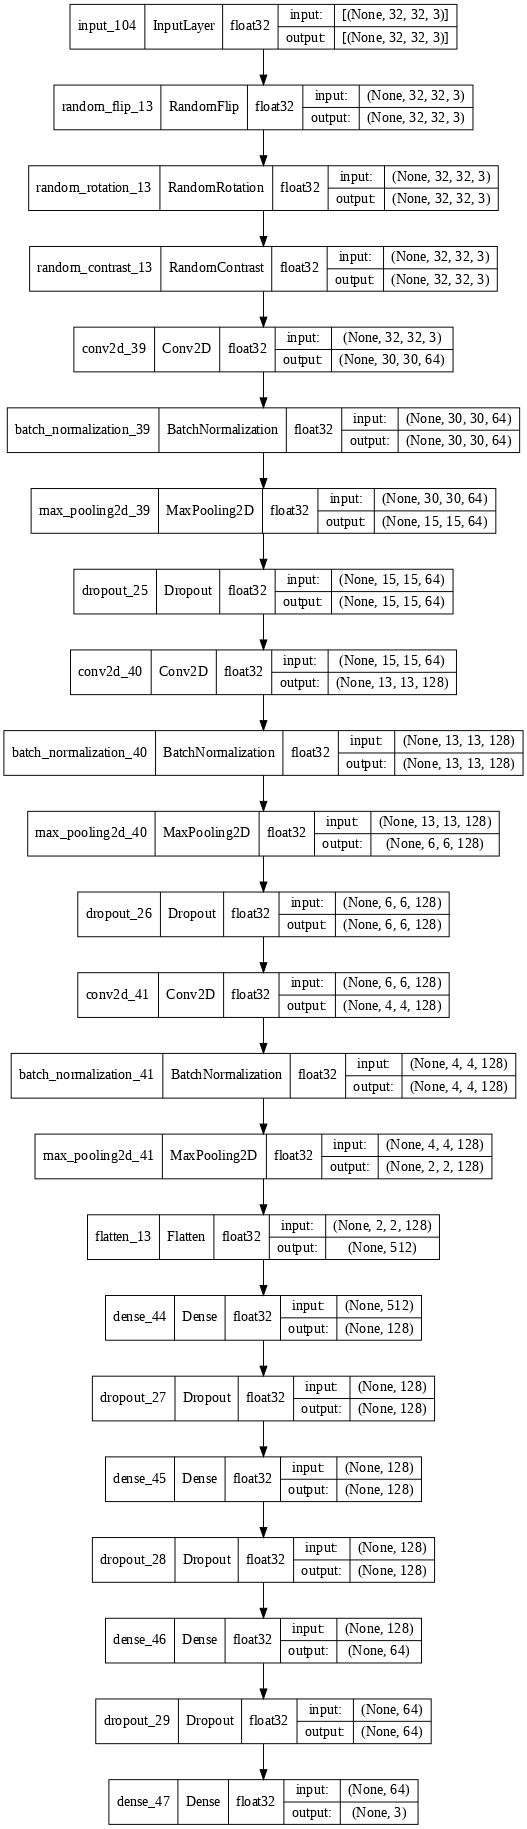

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

## Sequential Custom CNN Solution + Wide Inputs ( Model Experiment - 2 )






In [ ]:
layers = tf.keras.layers

wide_model4 = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInput1 = layers.Input(shape=(4,))
wideInput2 = layers.Input(shape=(4,))
wideInput3 = layers.Input(shape=(4,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)
#Feature Extraction Layers
#Conv Layer 1
x = layers.Conv2D(64, kernel_size=3, activation='relu')(aug)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 3
x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              #wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              #wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide_model4 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     #wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     #wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [ ]:
wide_model4.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_115 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_42 (MaxPooling2D  (None, 16, 16, 3)   0           ['input_115[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_30 (Dropout)           (None, 16, 16, 3)    0           ['max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_43 (Conv2D)             (None, 14, 14, 128)  3584        ['dropout_30[0][0]']      

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        #x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        #x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      #x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      #x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = wide_model4.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 47s 52ms/step - loss: 0.3880 - accuracy: 0.8266 - val_loss: 0.8209 - val_accuracy: 0.7667
Epoch 2/16
900/900 [==============================] - 46s 51ms/step - loss: 0.2878 - accuracy: 0.8764 - val_loss: 0.6821 - val_accuracy: 0.7732
Epoch 3/16
900/900 [==============================] - 45s 50ms/step - loss: 0.2589 - accuracy: 0.8920 - val_loss: 0.8912 - val_accuracy: 0.7703
Epoch 4/16
900/900 [==============================] - 45s 50ms/step - loss: 0.2383 - accuracy: 0.9014 - val_loss: 0.6907 - val_accuracy: 0.7743
Epoch 5/16
900/900 [==============================] - 46s 51ms/step - loss: 0.2123 - accuracy: 0.9149 - val_loss: 0.6369 - val_accuracy: 0.7718
Epoch 6/16
900/900 [==============================] - 44s 49ms/step - loss: 0.2028 - accuracy: 0.9181 - val_loss: 0.8050 - val_accuracy: 0.7764
Epoch 7/16
900/900 [==============================] - 45s 49ms/step - loss: 0.1893 - accuracy: 0.9262 - val_loss: 0.4234 - val_accuracy:

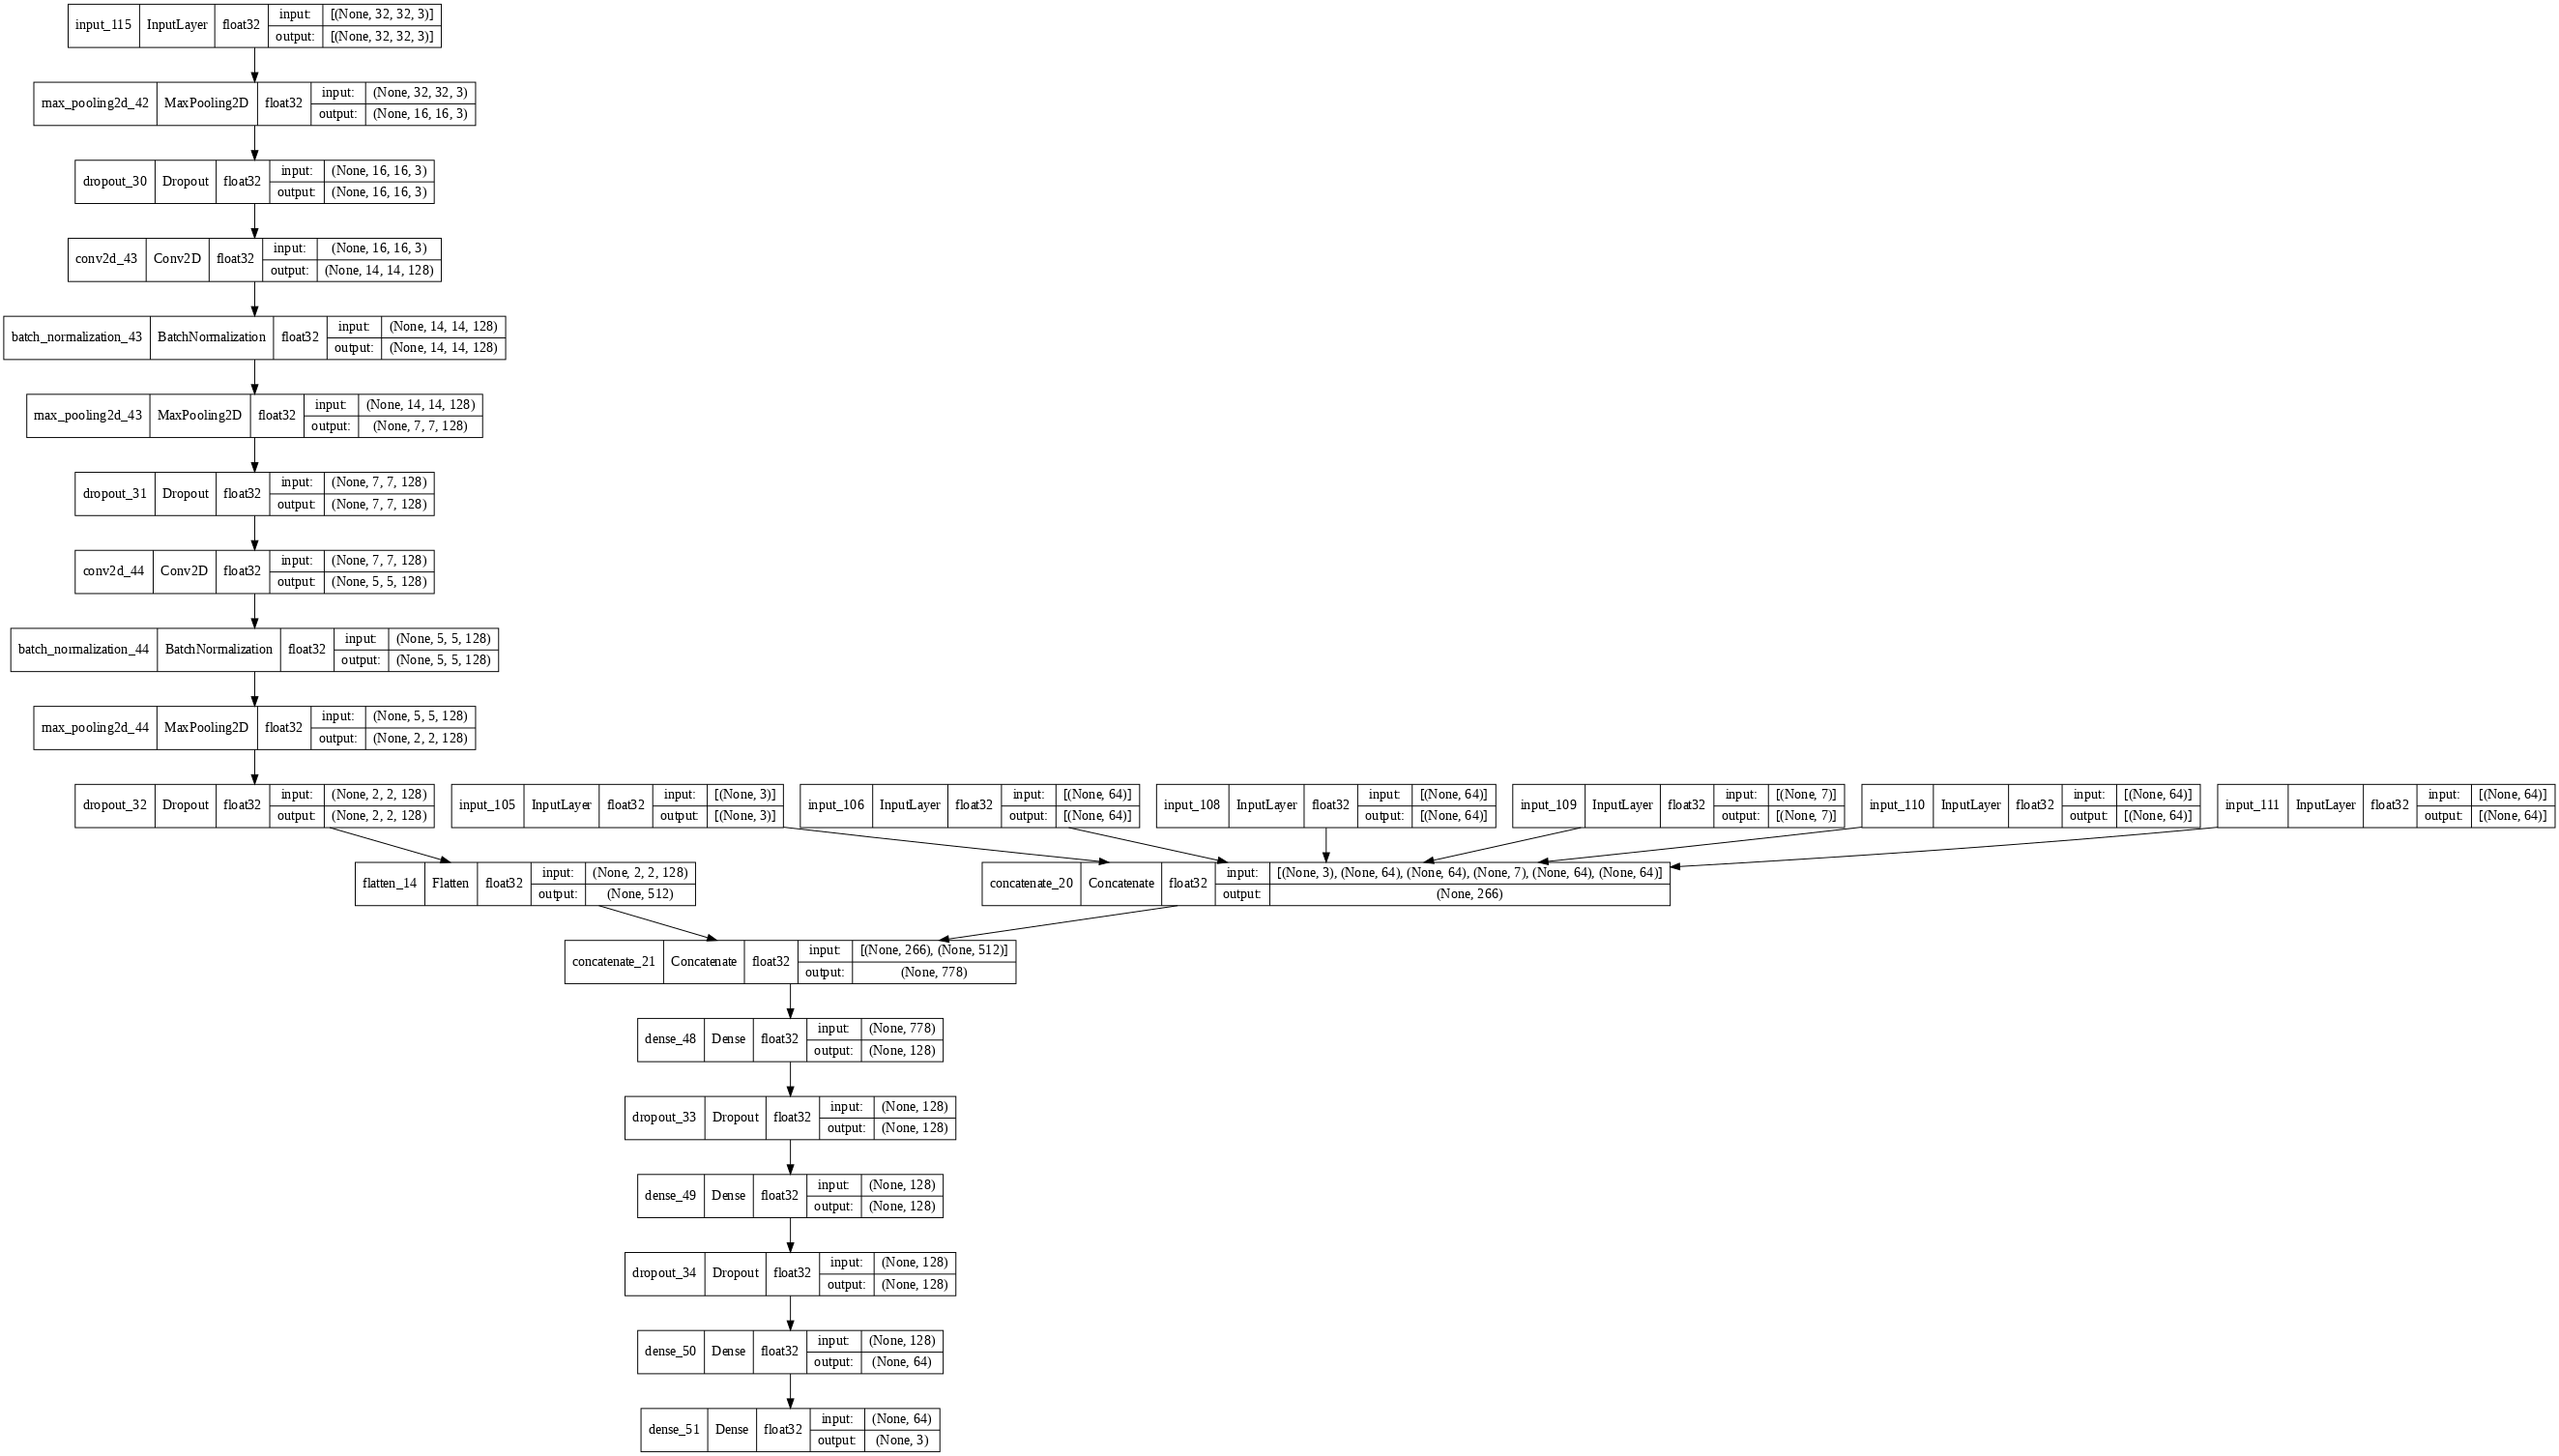

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_model4, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

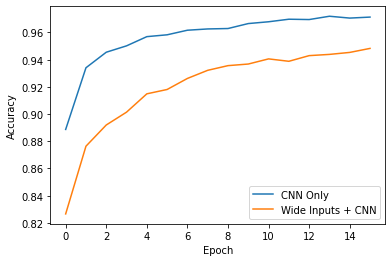

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs + CNN'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

In [ ]:

from matplotlib.pyplot import figure
plt.figure(figsize=(18, 10), dpi=65)
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN')

plt.plot(CORRhistory.history['accuracy'],label='>GLCM(Correlation) Only< Wide-CNN')
plt.plot(HOMOhistory.history['accuracy'],label='>GLCM(Homogenity) Only < Wide-CNN') 
plt.plot(history_mean_only.history['accuracy'],label='>Mean Value Only< Wide-CNN')
plt.plot(history_cnn.history['accuracy'],label='Deep Learning-CNN Only')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()



In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(x_test)
print(classification_report(y_test, y_pred))

# **4th Model Experiments**



## Sequential Custom CNN Solution Only ( Model Experiment - 4 )




In [ ]:
model = tf.keras.Sequential([                        
    layers.Input(shape=input_shape),
    #Conv Layer 1
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    #Conv Layer 2
    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    #Fully Connected Neural Network
    # Dense Layers
    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=3, activation='softmax')
])
# Choose the 'Adam' optimizer for Stochastic Gradient Descent
# https://arxiv.org/pdf/1609.04747.pdf
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 30, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 batch_normalization_21 (Bat  (None, 13, 13, 64)     

In [ ]:
history_cnn_exp2 = model.fit( x_train,
                         y_train,
                         validation_data=(x_test,y_test),
                         epochs=epochs, 
                         #callbacks = [reduce_lr]
                        )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 36s 40ms/step - loss: 0.2518 - accuracy: 0.9040 - val_loss: 0.3735 - val_accuracy: 0.8649
Epoch 2/16
900/900 [==============================] - 36s 40ms/step - loss: 0.1378 - accuracy: 0.9490 - val_loss: 0.9266 - val_accuracy: 0.7885
Epoch 3/16
900/900 [==============================] - 36s 40ms/step - loss: 0.1083 - accuracy: 0.9613 - val_loss: 0.9140 - val_accuracy: 0.8311
Epoch 4/16
900/900 [==============================] - 34s 38ms/step - loss: 0.0915 - accuracy: 0.9663 - val_loss: 0.2261 - val_accuracy: 0.9139
Epoch 5/16
900/900 [==============================] - 35s 39ms/step - loss: 0.0759 - accuracy: 0.9728 - val_loss: 0.0644 - val_accuracy: 0.9778
Epoch 6/16
900/900 [==============================] - 34s 38ms/step - loss: 0.0685 - accuracy: 0.9754 - val_loss: 1.9411 - val_accuracy: 0.7903
Epoch 7/16
900/900 [==============================] - 36s 40ms/step - loss: 0.0666 - accuracy: 0.9762 - val_loss: 0.5137 - val_accuracy:

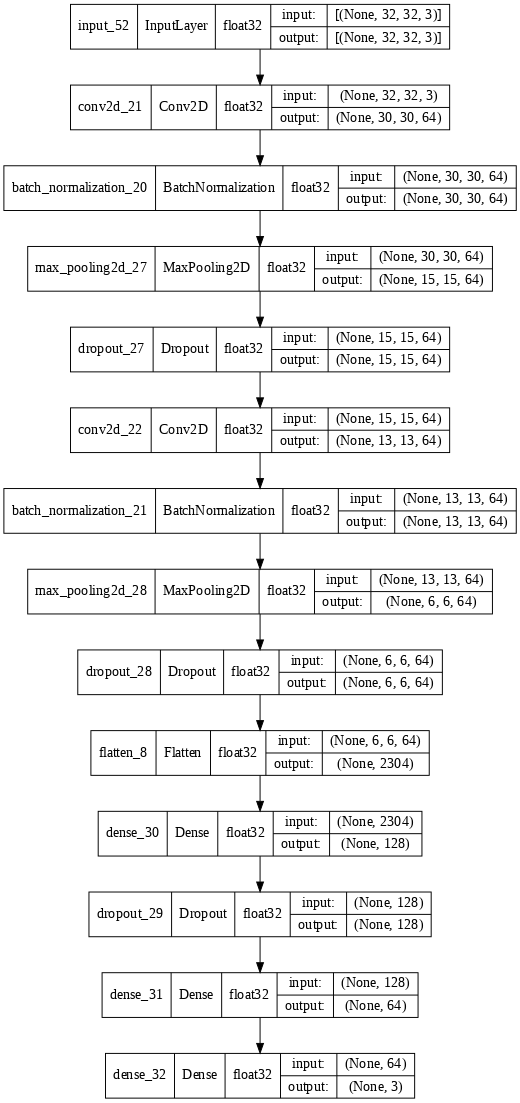

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
model, to_file='model.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

## Sequential Custom CNN Solution + Wide Inputs ( Model Experiment - 4 )






In [ ]:
layers = tf.keras.layers

wide_model4 = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide_model4 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 30, 30, 64)   1792        ['input_50[0][0]']               
                                                                                                  
 batch_normalization_16 (BatchN  (None, 30, 30, 64)  256         ['conv2d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 15, 15, 64)  0           ['batch_normalization_16[0]

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = wide_model4.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 38s 43ms/step - loss: 0.2499 - accuracy: 0.9072 - val_loss: 0.3765 - val_accuracy: 0.8497
Epoch 2/16
900/900 [==============================] - 39s 44ms/step - loss: 0.1337 - accuracy: 0.9526 - val_loss: 0.4008 - val_accuracy: 0.8743
Epoch 3/16
900/900 [==============================] - 39s 44ms/step - loss: 0.1045 - accuracy: 0.9618 - val_loss: 0.1179 - val_accuracy: 0.9563
Epoch 4/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0890 - accuracy: 0.9682 - val_loss: 0.4446 - val_accuracy: 0.8518
Epoch 5/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0811 - accuracy: 0.9697 - val_loss: 0.1290 - val_accuracy: 0.9482
Epoch 6/16
900/900 [==============================] - 40s 44ms/step - loss: 0.0729 - accuracy: 0.9741 - val_loss: 0.2952 - val_accuracy: 0.9024
Epoch 7/16
900/900 [==============================] - 39s 44ms/step - loss: 0.0651 - accuracy: 0.9769 - val_loss: 0.0748 - val_accuracy:

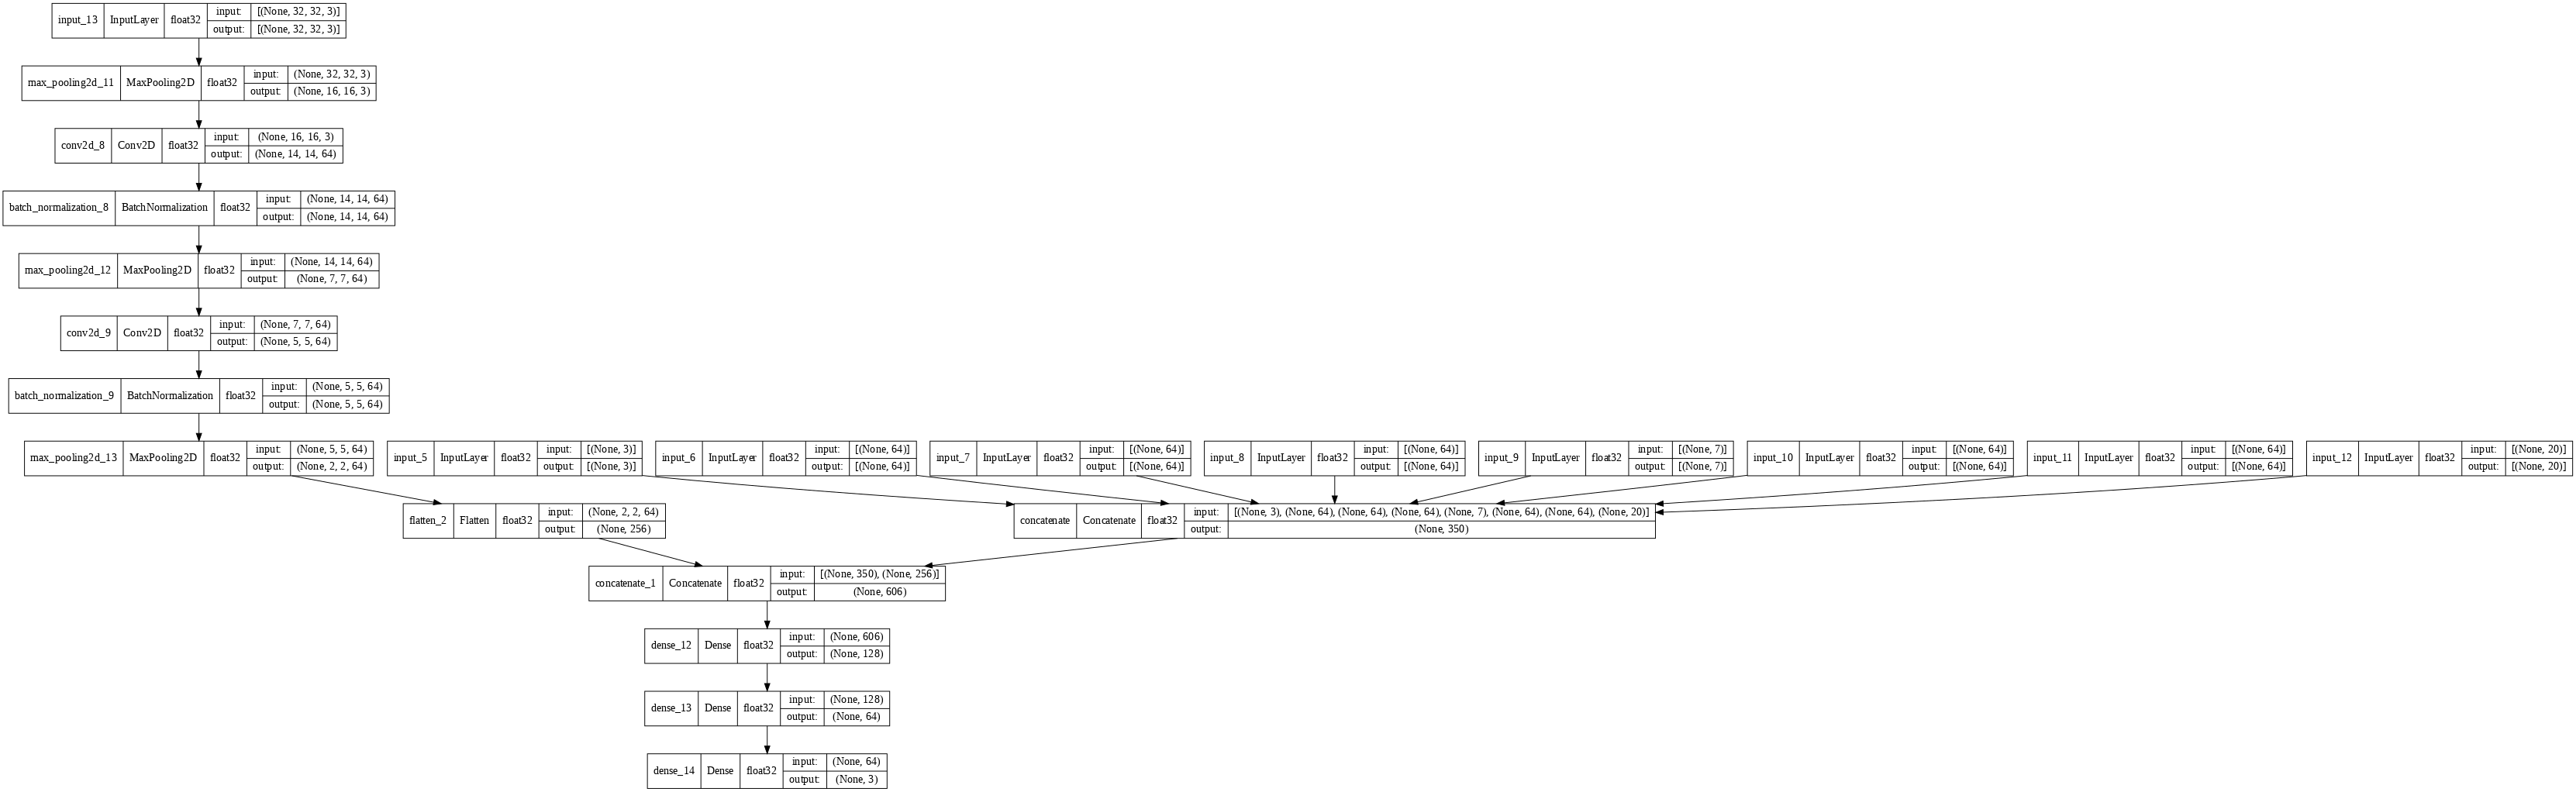

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_model4, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

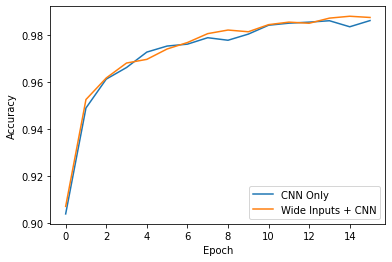

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs + CNN'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

## Sequential Custom CNN Solution + Wide Inputs ( Model Experiment - 4 )






In [ ]:
layers = tf.keras.layers

wide_model128 = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide_model128 = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_model128.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_model128.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 30, 30, 64)   1792        ['input_61[0][0]']               
                                                                                                  
 batch_normalization_22 (BatchN  (None, 30, 30, 64)  256         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_29 (MaxPooling2D  (None, 15, 15, 64)  0           ['batch_normalization_22[0]

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_wide_model128 = wide_model128.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 39s 44ms/step - loss: 0.2064 - accuracy: 0.9222 - val_loss: 1.1364 - val_accuracy: 0.7679
Epoch 2/16
900/900 [==============================] - 39s 43ms/step - loss: 0.1213 - accuracy: 0.9547 - val_loss: 0.6298 - val_accuracy: 0.7993
Epoch 3/16
900/900 [==============================] - 40s 44ms/step - loss: 0.0923 - accuracy: 0.9661 - val_loss: 0.2921 - val_accuracy: 0.8833
Epoch 4/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0725 - accuracy: 0.9732 - val_loss: 0.4331 - val_accuracy: 0.8624
Epoch 5/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0652 - accuracy: 0.9776 - val_loss: 0.2772 - val_accuracy: 0.8881
Epoch 6/16
900/900 [==============================] - 39s 43ms/step - loss: 0.0635 - accuracy: 0.9783 - val_loss: 0.6769 - val_accuracy: 0.8344
Epoch 7/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.2719 - val_accuracy:

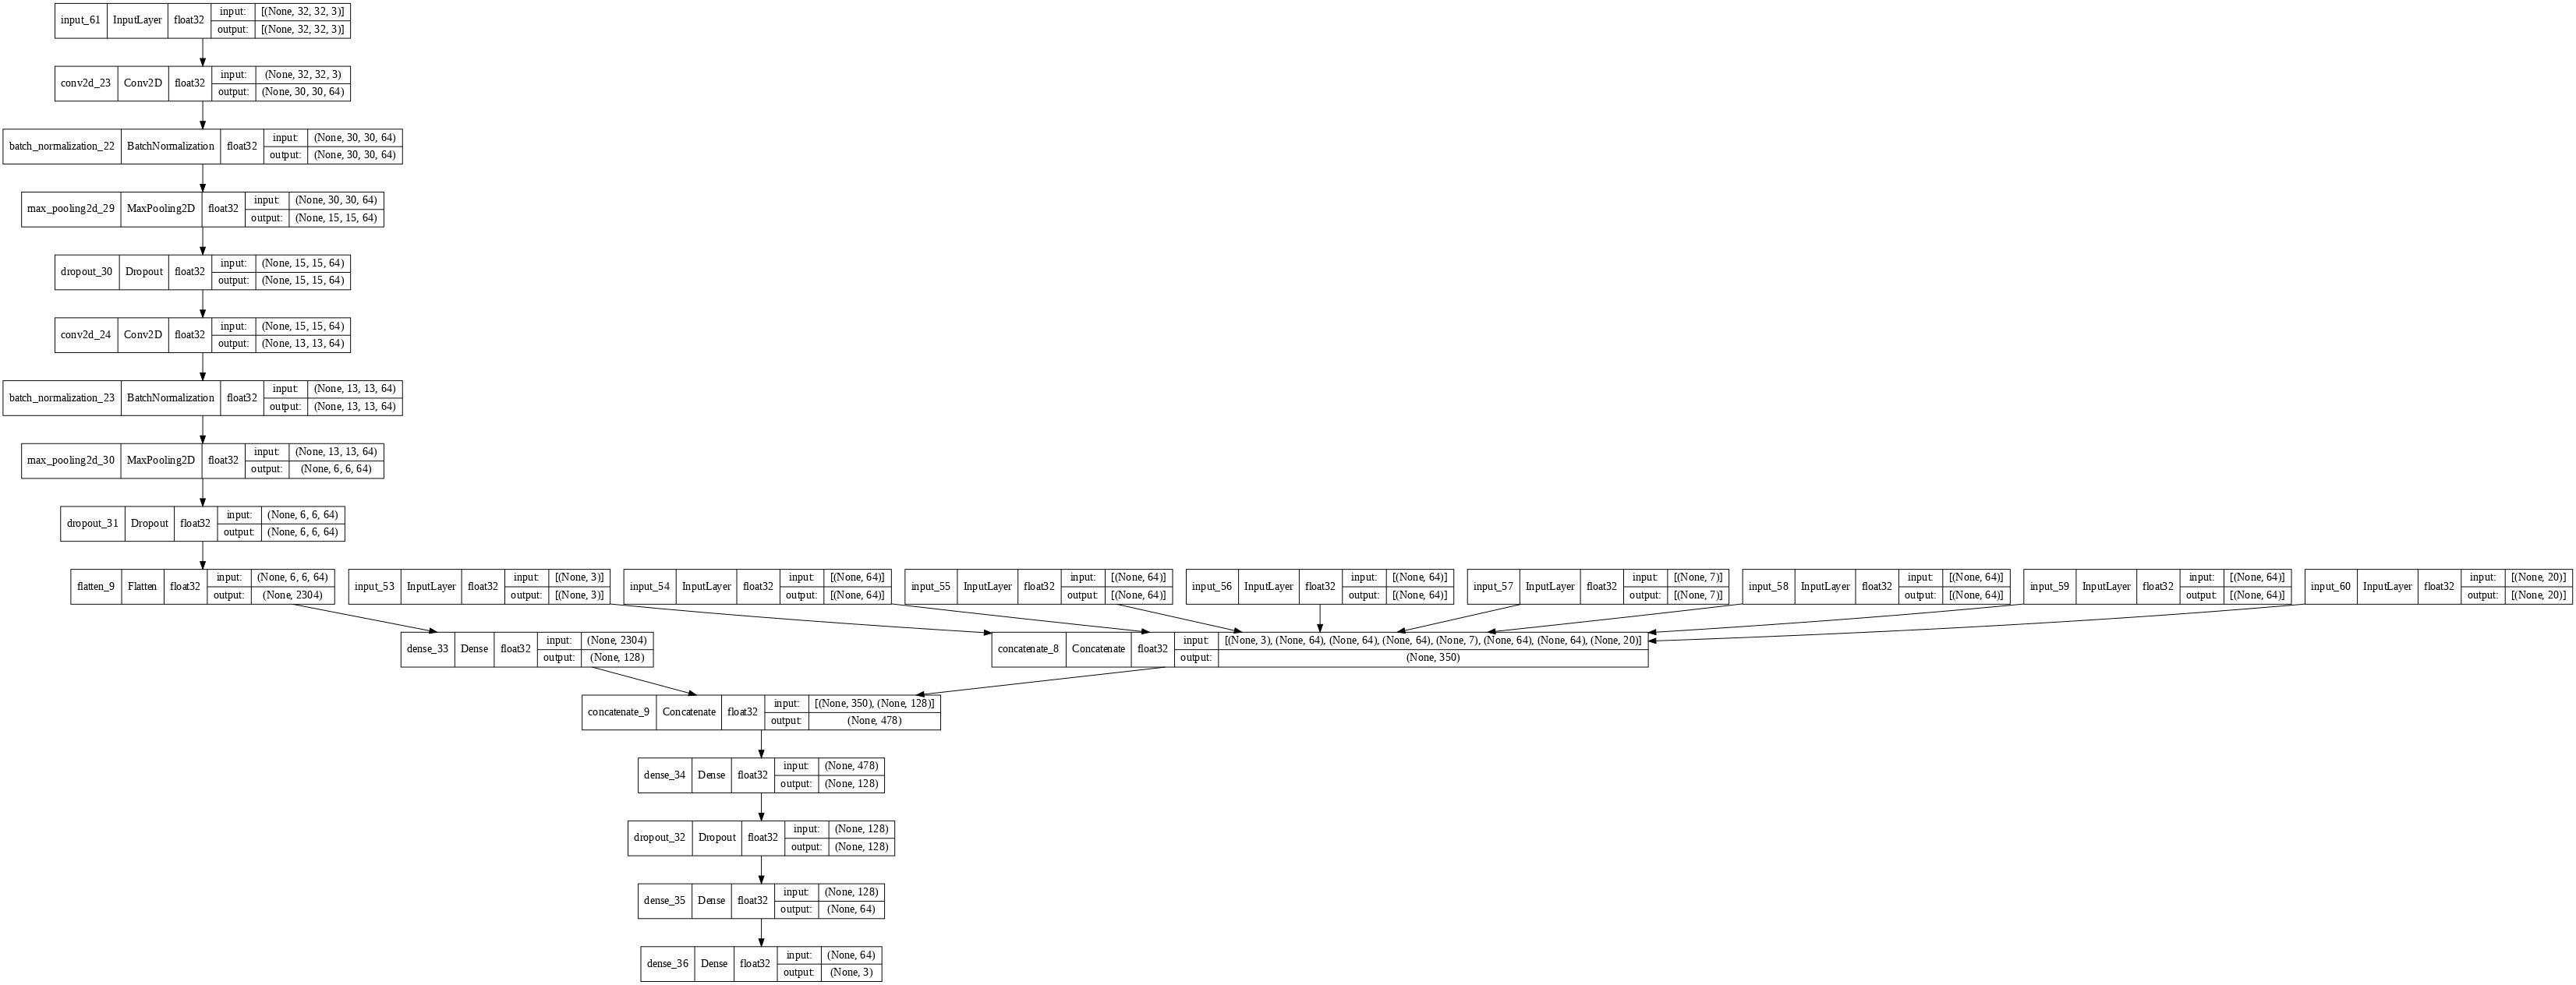

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_model128, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

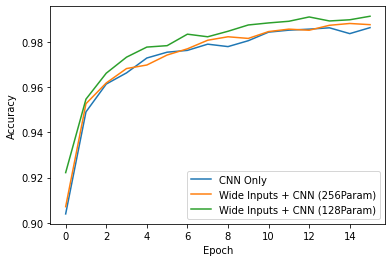

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.plot(ALLhistory_wide_model128.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs + CNN (256Param)', 'Wide Inputs + CNN (128Param)'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=400)  
plt.savefig('aLLhistory.pdf')

## Sequential Custom CNN Solution + Wide Inputs ( Model Experiment - 4 )






In [ ]:
layers = tf.keras.layers

wide_modelInvariant = tf.keras.Sequential()                              
#layers.Reshape((3072,), input_shape=(input_shape)),

#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#Feature Extraction Layers
#Conv Layer 1
#x = layers.MaxPooling2D((2, 2))(wideInputD)
x = layers.Conv2D(64, kernel_size=3, activation='relu')(wideInputD)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
#Conv Layer 2
x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
#x = layers.Dense(units=128, activation='relu')(x)
# Concatenate Wide + Deep Inputs
merged = tf.keras.layers.Concatenate(axis=1)([#wideInput0,
                                              #wideInputInvariantRed,
                                              #wideInputInvariantGreen,
                                              #wideInputInvariantBlue, 
                                              #wideInputHU,
                                              #wideInputHOG,
                                              #wideInputLPB,
                                              wideInputGLCM
                                              ])
merged2 = layers.Concatenate(axis=1)([merged, x])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=128, activation='relu')(merged2)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=64, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

wide_modelInvariant = tf.keras.Model(inputs=[#wideInput0, 
                                     #wideInputInvariantRed,
                                     #wideInputInvariantGreen,
                                     #wideInputInvariantBlue, 
                                     #wideInputHU,
                                     #wideInputHOG,
                                     #wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

wide_modelInvariant.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
wide_modelInvariant.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_124 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 30, 30, 64)   1792        ['input_124[0][0]']              
                                                                                                  
 batch_normalization_36 (BatchN  (None, 30, 30, 64)  256         ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_43 (MaxPooling2D  (None, 15, 15, 64)  0           ['batch_normalization_36[0

In [ ]:
GLCMdata_trainMerged = [#x_train_mean ,
                        #x_train_invariant_Red,
                        #x_train_invariant_Green,
                        #x_train_invariant_Blue,
                        #x_train_HU,
                        #x_train_hog_vector,
                        #x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [#x_test_mean,
                      #x_test_invariant_Red, 
                      #x_test_invariant_Green,
                      #x_test_invariant_Blue,
                      #x_test_HU,
                      #x_test_hog_vector,
                      #x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_wide_modelInvariant = wide_modelInvariant.fit(GLCMdata_trainMerged, 
                             y_train,
                             epochs = epochs,
                             validation_data=(GLCMdata_valMerged, y_test),
                             #callbacks = [reduce_lr]
                             )
                                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 36s 40ms/step - loss: 0.2455 - accuracy: 0.9079 - val_loss: 0.1915 - val_accuracy: 0.9275
Epoch 2/16
900/900 [==============================] - 37s 41ms/step - loss: 0.1274 - accuracy: 0.9522 - val_loss: 0.1257 - val_accuracy: 0.9529
Epoch 3/16
900/900 [==============================] - 37s 41ms/step - loss: 0.1063 - accuracy: 0.9624 - val_loss: 0.5953 - val_accuracy: 0.8268
Epoch 4/16
900/900 [==============================] - 37s 41ms/step - loss: 0.0903 - accuracy: 0.9680 - val_loss: 0.9164 - val_accuracy: 0.8046
Epoch 5/16
900/900 [==============================] - 36s 40ms/step - loss: 0.0790 - accuracy: 0.9719 - val_loss: 0.0902 - val_accuracy: 0.9660
Epoch 6/16
900/900 [==============================] - 36s 40ms/step - loss: 0.0698 - accuracy: 0.9744 - val_loss: 0.1699 - val_accuracy: 0.9364
Epoch 7/16
900/900 [==============================] - 38s 42ms/step - loss: 0.0660 - accuracy: 0.9761 - val_loss: 0.1036 - val_accuracy:

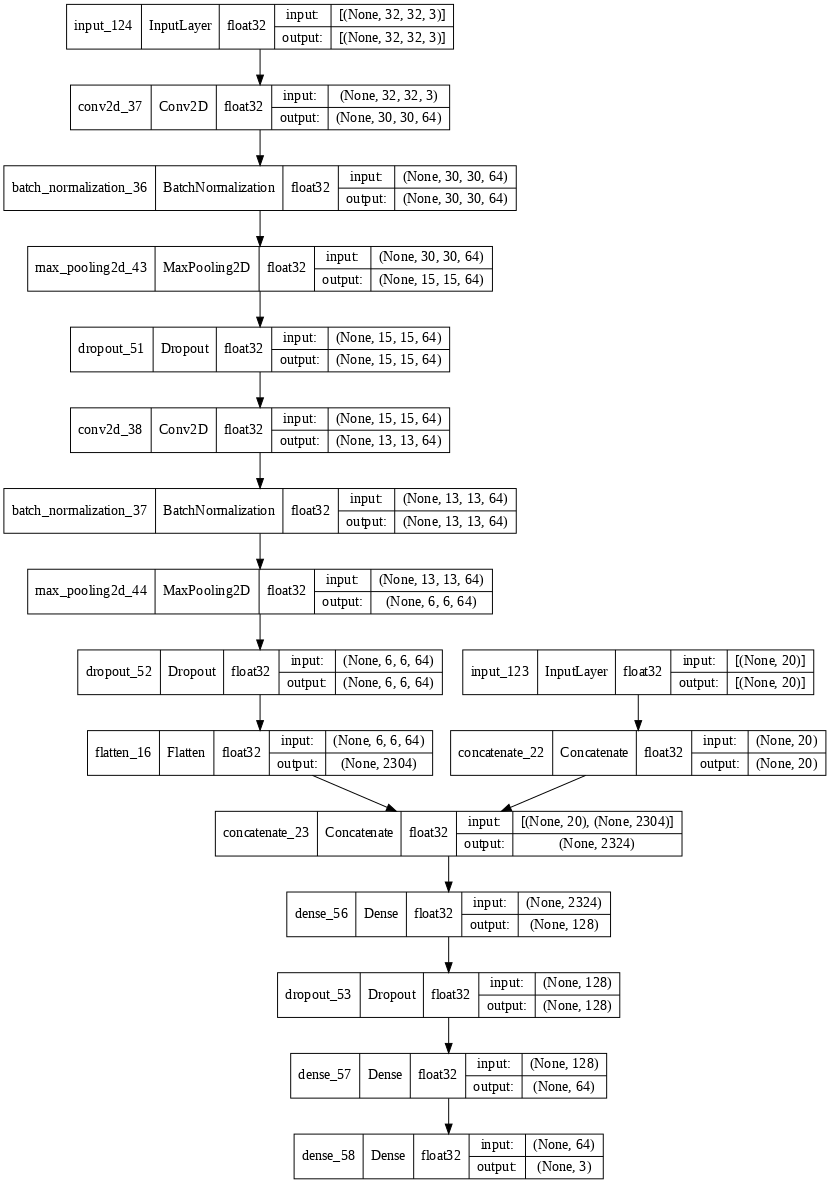

In [ ]:
#Model Plotting..
tf.keras.utils.plot_model(
wide_modelInvariant, to_file='modelwide.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=True, dpi=70
)

**RESULTS**

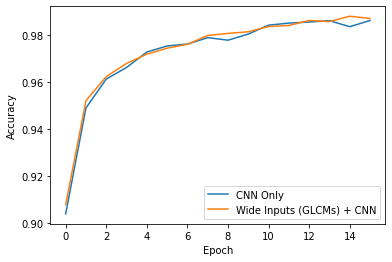

In [ ]:
plt.plot(history_cnn_exp2.history['accuracy'])
plt.plot(ALLhistory_wide_modelInvariant.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CNN Only', 'Wide Inputs (GLCMs) + CNN'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=400)  
plt.savefig('aLLhistory.pdf')

# **Pre-trained Model Experiments**

---



# VGG16 Tests:
16 Epochs:

  Wide And Deep:
*    512 Param Deep Input + 350 Param Wide Input  : .9598 Accuracy Max
*    256 Param Deep Input + 350 Param Wide Input  : .9675 Accuracy Max
*    128 Param Deep Input + 350 Param Wide Input  : .9665 Accuracy Max

Deep Only:
*     512 Param Deep Input: .9642 Accuracy Max



# VGG16 512Param Deep Input + 350 Param Wide Input

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                           

In [ ]:
history_VGG16 = VGG16_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 67s 144ms/step - loss: 0.2618 - accuracy: 0.8877 - val_loss: 0.1881 - val_accuracy: 0.9207
Epoch 2/16
450/450 [==============================] - 61s 136ms/step - loss: 0.1900 - accuracy: 0.9203 - val_loss: 0.1670 - val_accuracy: 0.9301
Epoch 3/16
450/450 [==============================] - 54s 119ms/step - loss: 0.1720 - accuracy: 0.9285 - val_loss: 0.1706 - val_accuracy: 0.9287
Epoch 4/16
450/450 [==============================] - 48s 107ms/step - loss: 0.1559 - accuracy: 0.9370 - val_loss: 0.1474 - val_accuracy: 0.9383
Epoch 5/16
450/450 [==============================] - 51s 113ms/step - loss: 0.1399 - accuracy: 0.9436 - val_loss: 0.1397 - val_accuracy: 0.9418
Epoch 6/16
450/450 [==============================] - 49s 109ms/step - loss: 0.1344 - accuracy: 0.9444 - val_loss: 0.1435 - val_accuracy: 0.9429
Epoch 7/16
450/450 [==============================] - 49s 110ms/step - loss: 0.1287 - accuracy: 0.9473 - val_loss: 0.1312 - val_ac

In [ ]:
VGG16WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

VGG16WIDE_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 58s 128ms/step - loss: 0.2804 - accuracy: 0.8776 - val_loss: 0.1996 - val_accuracy: 0.9169
Epoch 2/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1930 - accuracy: 0.9198 - val_loss: 0.1629 - val_accuracy: 0.9306
Epoch 3/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1728 - accuracy: 0.9283 - val_loss: 0.1587 - val_accuracy: 0.9324
Epoch 4/16
450/450 [==============================] - 52s 116ms/step - loss: 0.1577 - accuracy: 0.9355 - val_loss: 0.1738 - val_accuracy: 0.9285
Epoch 5/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1509 - accuracy: 0.9392 - val_loss: 0.1527 - val_accuracy: 0.9372
Epoch 6/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1357 - accuracy: 0.9448 - val_loss: 0.1350 - val_accuracy: 0.9451
Epoch 7/16
450/450 [==============================] - 51s 114ms/step - loss: 0.1304 - accuracy: 0.9471 - val_loss: 0.1708 - val_ac

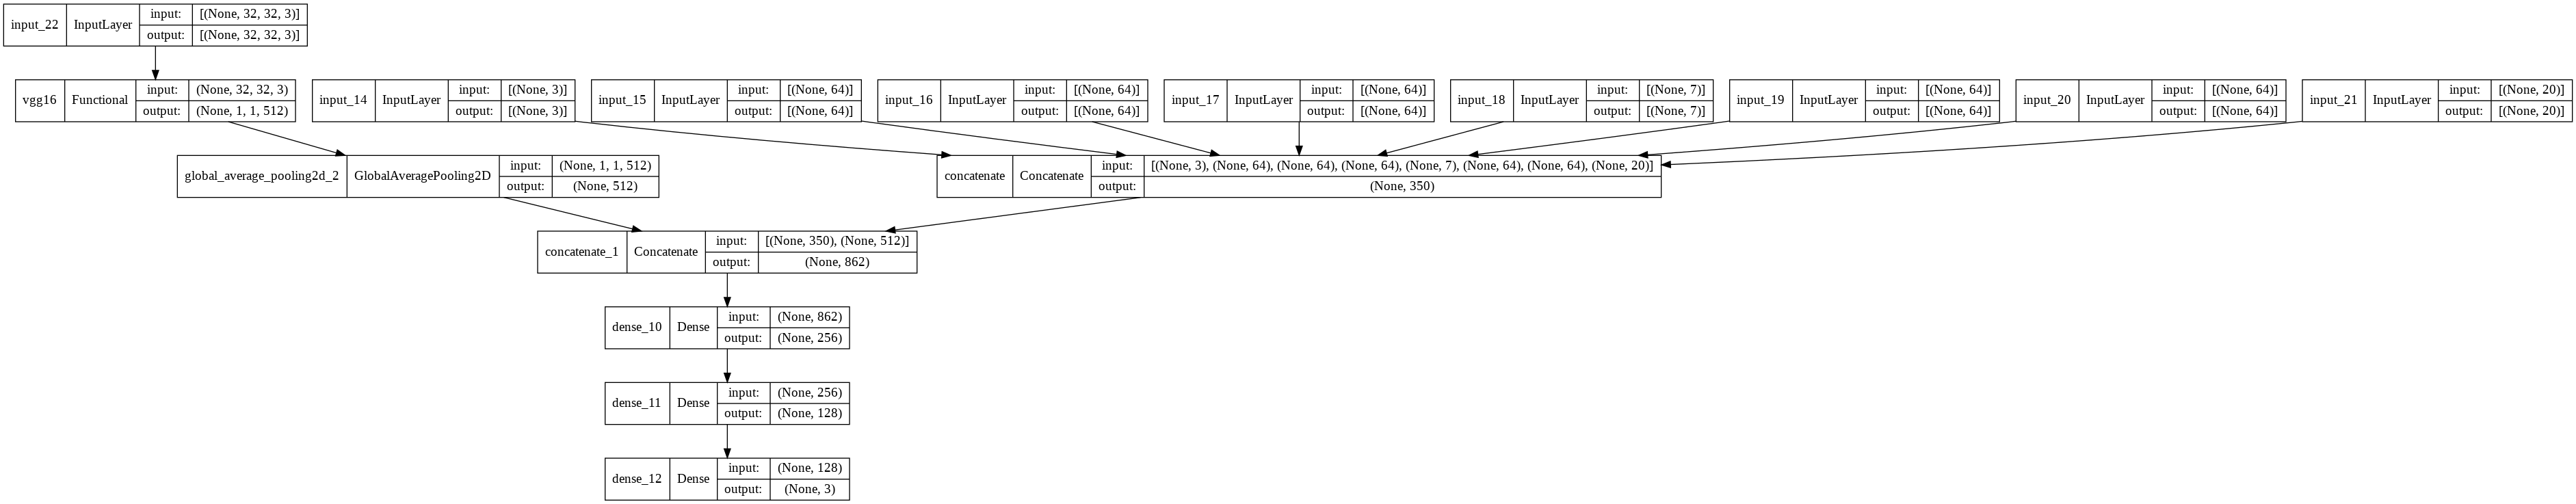

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

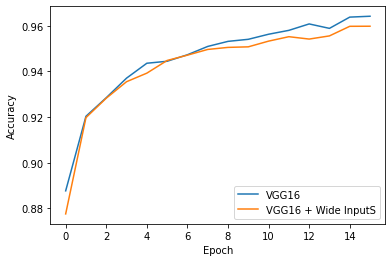

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# VGG16 256Param Deep Input + 350 Param Wide Input

In [ ]:
VGG16WIDE256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

VGG16WIDE256_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 65s 144ms/step - loss: 0.2684 - accuracy: 0.8847 - val_loss: 0.2056 - val_accuracy: 0.9135
Epoch 2/16
450/450 [==============================] - 52s 117ms/step - loss: 0.1814 - accuracy: 0.9249 - val_loss: 0.1596 - val_accuracy: 0.9339
Epoch 3/16
450/450 [==============================] - 53s 118ms/step - loss: 0.1606 - accuracy: 0.9351 - val_loss: 0.1606 - val_accuracy: 0.9344
Epoch 4/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1491 - accuracy: 0.9399 - val_loss: 0.1339 - val_accuracy: 0.9438
Epoch 5/16
450/450 [==============================] - 53s 118ms/step - loss: 0.1330 - accuracy: 0.9467 - val_loss: 0.1361 - val_accuracy: 0.9433
Epoch 6/16
450/450 [==============================] - 53s 117ms/step - loss: 0.1264 - accuracy: 0.9494 - val_loss: 0.1869 - val_accuracy: 0.9224
Epoch 7/16
450/450 [==============================] - 53s 118ms/step - loss: 0.1213 - accuracy: 0.9522 - val_loss: 0.1479 - val_ac

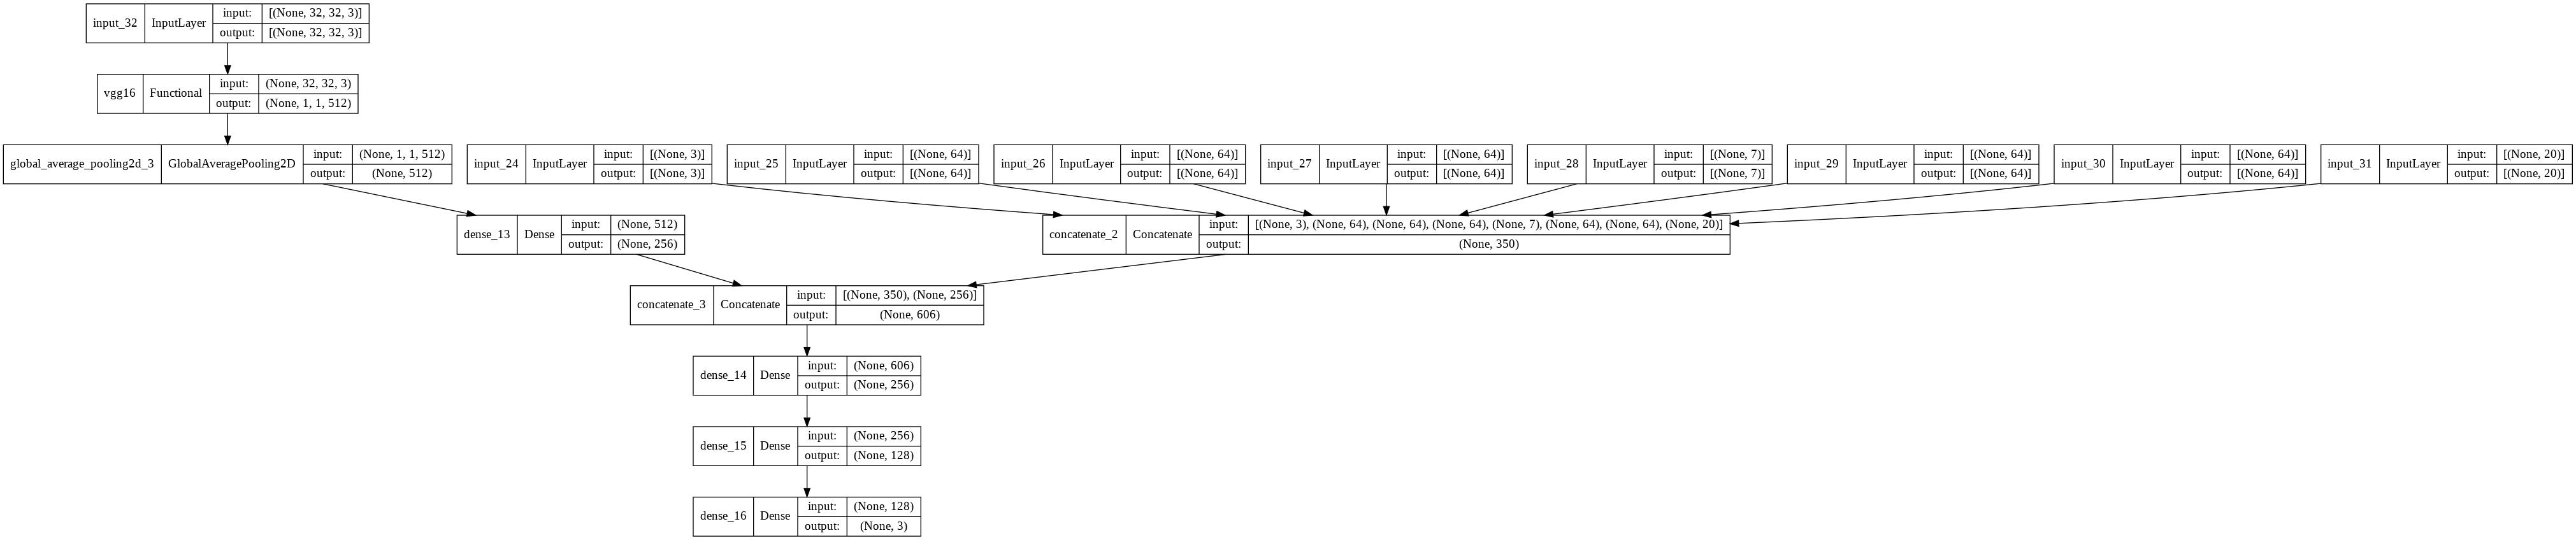

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE256_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

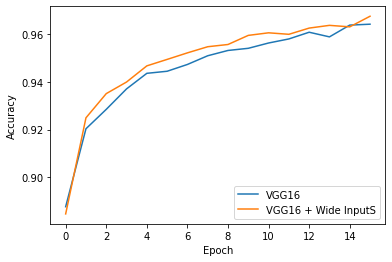

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# VGG16 128Param Deep Input + 350 Param Wide Input

In [ ]:
VGG16WIDE128_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=128, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

VGG16WIDE128_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE128_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                       ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                     ]

history_VGG16WIDE128 = VGG16WIDE128_model.fit(GLCMdata_trainMerged, 
                                              y_train,
                                              epochs = epochs,
                                              batch_size = batch_size,
                                              validation_data=(GLCMdata_valMerged, y_test),
                                              #callbacks = [reduce_lr]
                                             )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 62s 138ms/step - loss: 0.2645 - accuracy: 0.8878 - val_loss: 0.1890 - val_accuracy: 0.9239
Epoch 2/16
450/450 [==============================] - 54s 119ms/step - loss: 0.1890 - accuracy: 0.9223 - val_loss: 0.1935 - val_accuracy: 0.9200
Epoch 3/16
450/450 [==============================] - 58s 129ms/step - loss: 0.1657 - accuracy: 0.9324 - val_loss: 0.1960 - val_accuracy: 0.9217
Epoch 4/16
450/450 [==============================] - 63s 140ms/step - loss: 0.1497 - accuracy: 0.9392 - val_loss: 0.1517 - val_accuracy: 0.9417
Epoch 5/16
450/450 [==============================] - 53s 118ms/step - loss: 0.1418 - accuracy: 0.9425 - val_loss: 0.1465 - val_accuracy: 0.9414
Epoch 6/16
450/450 [==============================] - 55s 123ms/step - loss: 0.1346 - accuracy: 0.9464 - val_loss: 0.1477 - val_accuracy: 0.9404
Epoch 7/16
450/450 [==============================] - 54s 119ms/step - loss: 0.1231 - accuracy: 0.9511 - val_loss: 0.1290 - val_ac

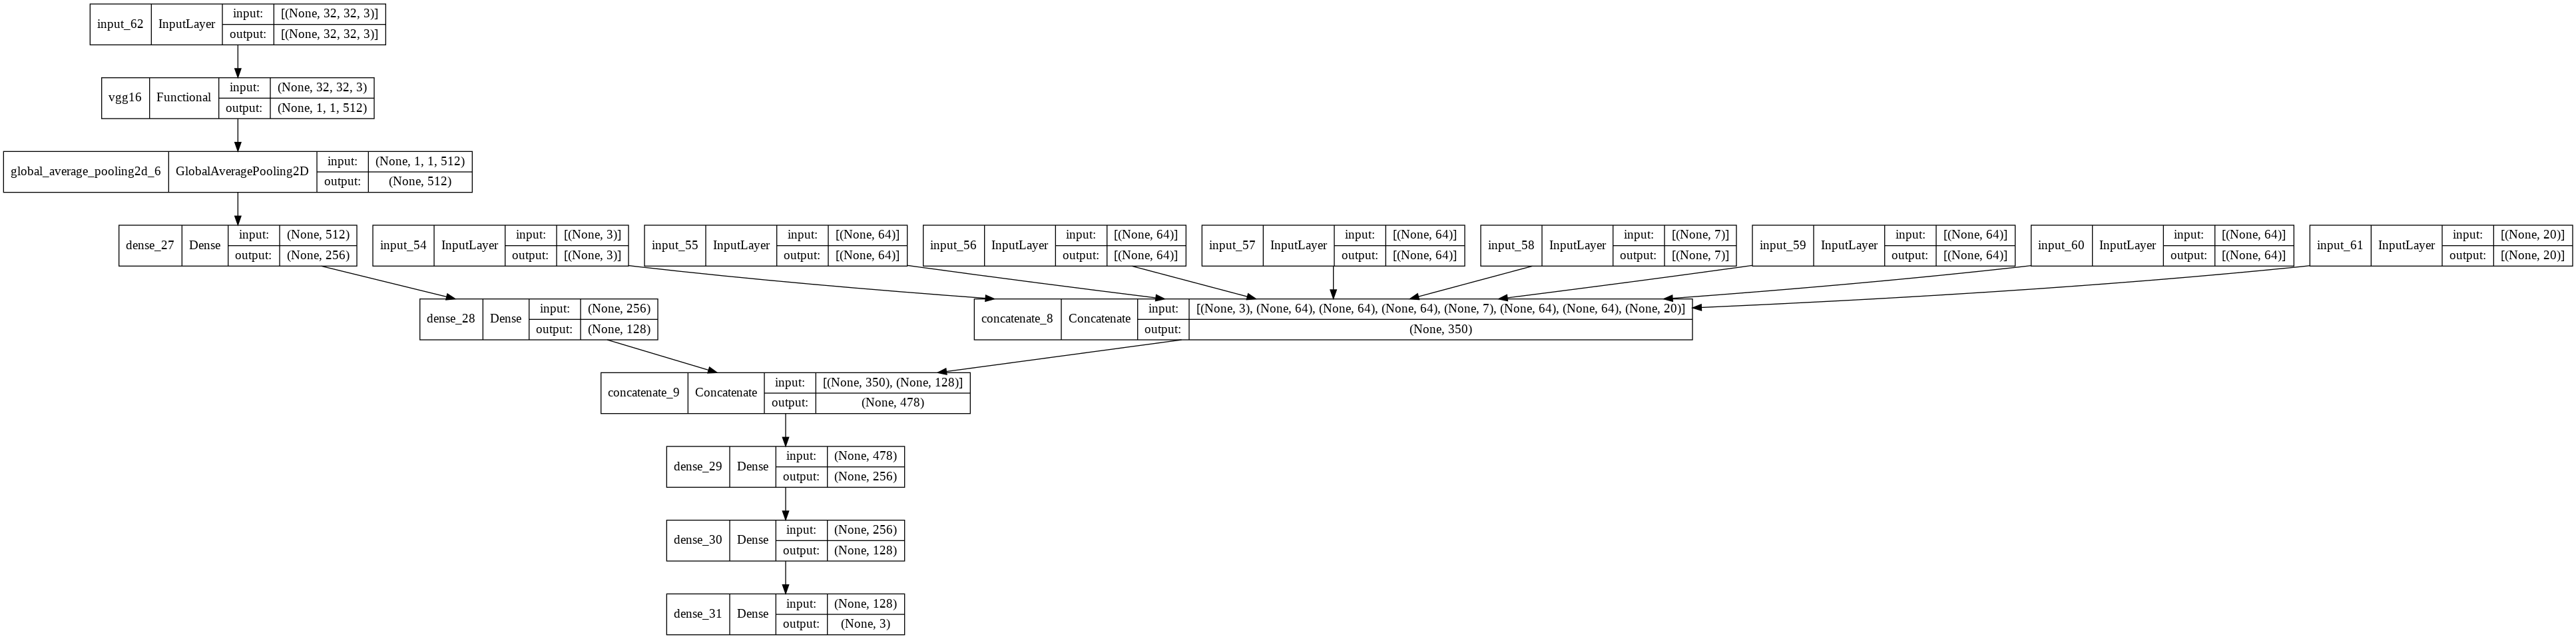

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE128_model, to_file='VGG16WIDE128_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

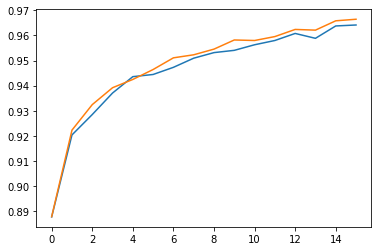

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE128.history['accuracy'])
plt.plot(history_VGG16WIDE256.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 128Inp. + Wide InputS', 'VGG16 256Inp. + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

VGG16_model = Model(inputs = inputs, outputs = predictions)
VGG16_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
VGG16_model.summary()

ValueError: ignored

In [ ]:
history_VGG16 = VGG16_model.fit( x_train,
                                y_train,
                                validation_data=(x_test,y_test),
                                epochs=epochs,
                                batch_size = batch_size
                                #callbacks=[reduce_lr]
                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 67s 144ms/step - loss: 0.2618 - accuracy: 0.8877 - val_loss: 0.1881 - val_accuracy: 0.9207
Epoch 2/16
450/450 [==============================] - 61s 136ms/step - loss: 0.1900 - accuracy: 0.9203 - val_loss: 0.1670 - val_accuracy: 0.9301
Epoch 3/16
450/450 [==============================] - 54s 119ms/step - loss: 0.1720 - accuracy: 0.9285 - val_loss: 0.1706 - val_accuracy: 0.9287
Epoch 4/16
450/450 [==============================] - 48s 107ms/step - loss: 0.1559 - accuracy: 0.9370 - val_loss: 0.1474 - val_accuracy: 0.9383
Epoch 5/16
450/450 [==============================] - 51s 113ms/step - loss: 0.1399 - accuracy: 0.9436 - val_loss: 0.1397 - val_accuracy: 0.9418
Epoch 6/16
450/450 [==============================] - 49s 109ms/step - loss: 0.1344 - accuracy: 0.9444 - val_loss: 0.1435 - val_accuracy: 0.9429
Epoch 7/16
450/450 [==============================] - 49s 110ms/step - loss: 0.1287 - accuracy: 0.9473 - val_loss: 0.1312 - val_ac

In [ ]:
VGG16WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))

base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

VGG16WIDE_model = tf.keras.Model( inputs=[wideInput0, 
                                        wideInputInvariantRed,
                                        wideInputInvariantGreen,
                                        wideInputInvariantBlue, 
                                        wideInputHU,
                                        wideInputHOG,
                                        wideInputLPB,
                                        wideInputGLCM, 
                                        wideInputD
                                              ],  
                                        outputs=merged_out)

VGG16WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_VGG16WIDE = VGG16WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 58s 128ms/step - loss: 0.2804 - accuracy: 0.8776 - val_loss: 0.1996 - val_accuracy: 0.9169
Epoch 2/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1930 - accuracy: 0.9198 - val_loss: 0.1629 - val_accuracy: 0.9306
Epoch 3/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1728 - accuracy: 0.9283 - val_loss: 0.1587 - val_accuracy: 0.9324
Epoch 4/16
450/450 [==============================] - 52s 116ms/step - loss: 0.1577 - accuracy: 0.9355 - val_loss: 0.1738 - val_accuracy: 0.9285
Epoch 5/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1509 - accuracy: 0.9392 - val_loss: 0.1527 - val_accuracy: 0.9372
Epoch 6/16
450/450 [==============================] - 52s 115ms/step - loss: 0.1357 - accuracy: 0.9448 - val_loss: 0.1350 - val_accuracy: 0.9451
Epoch 7/16
450/450 [==============================] - 51s 114ms/step - loss: 0.1304 - accuracy: 0.9471 - val_loss: 0.1708 - val_ac

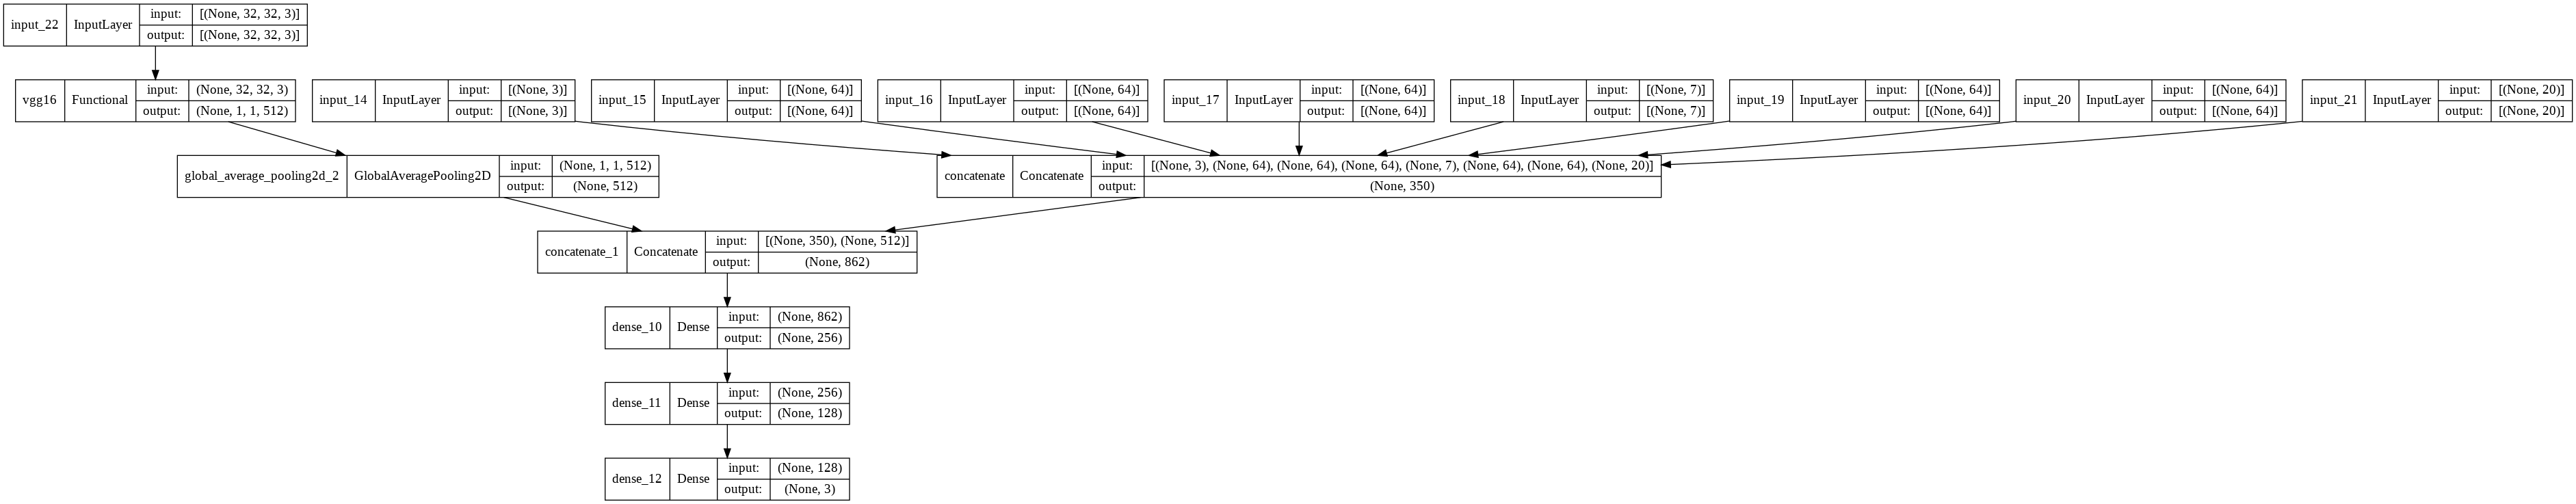

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
VGG16WIDE_model, to_file='VGG16WIDE_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

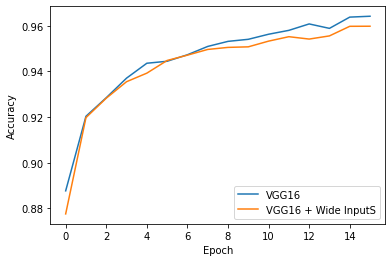

In [ ]:
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16', 'VGG16 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# ResNet50v2 Tests:
16 Epochs:

  Wide And Deep:
*    2048 Param Deep Input + 350 Param Wide Input  : .9295 Accuracy Max ????
*    1024 Param Deep Input + 350 Param Wide Input  : .9691 Accuracy Max
*    512 Param Deep Input + 350 Param Wide Input   : Testing..

Deep Only:
*     2048 Param Deep Input: .9876 Accuracy Max



# ResNet50v2 2048 Param Deep Input + 350 Param Wide Input

In [ ]:

from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

ResNet50V2_model = Model(inputs = inputs, outputs = predictions)

ResNet50V2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
ResNet50V2_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_76 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_77 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_78 (Dense)            (None, 512)               524800    
                                                          

In [ ]:
history_ResNet50V2 = ResNet50V2_model.fit( 
    x_train,
    y_train,
    validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 155s 343ms/step - loss: 0.3930 - accuracy: 0.8312 - val_loss: 0.3203 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/16
450/450 [==============================] - 115s 255ms/step - loss: 0.3037 - accuracy: 0.8662 - val_loss: 0.3232 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 3/16
450/450 [==============================] - 95s 210ms/step - loss: 0.2616 - accuracy: 0.8860 - val_loss: 0.3157 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 4/16
450/450 [==============================] - 93s 206ms/step - loss: 0.2305 - accuracy: 0.8994 - val_loss: 0.3260 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 5/16
450/450 [==============================] - 92s 204ms/step - loss: 0.2019 - accuracy: 0.9111 - val_loss: 0.3292 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 6/16
450/450 [==============================] - 102s 227ms/step - loss: 0.1784 - accuracy: 0.9224 - val_loss: 0.3896 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 7/16
450/450 [=============================

In [ ]:
ResNet50V2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

ResNet50V2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
ResNet50V2WIDE_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_96 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_88 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_89 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_90 (InputLayer)          [(None, 64)]         0           []                               
                                                                                           

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE = ResNet50V2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 112s 249ms/step - loss: 0.3992 - accuracy: 0.8272 - val_loss: 0.3147 - val_accuracy: 0.8585
Epoch 2/16
450/450 [==============================] - 104s 231ms/step - loss: 0.3201 - accuracy: 0.8607 - val_loss: 0.3694 - val_accuracy: 0.8506
Epoch 3/16
450/450 [==============================] - 95s 211ms/step - loss: 0.2856 - accuracy: 0.8737 - val_loss: 0.2735 - val_accuracy: 0.8888
Epoch 4/16
450/450 [==============================] - 95s 211ms/step - loss: 0.2693 - accuracy: 0.8815 - val_loss: 0.2950 - val_accuracy: 0.8810
Epoch 5/16
450/450 [==============================] - 103s 230ms/step - loss: 0.2475 - accuracy: 0.8930 - val_loss: 0.2834 - val_accuracy: 0.8908
Epoch 6/16
450/450 [==============================] - 94s 209ms/step - loss: 0.2365 - accuracy: 0.8969 - val_loss: 0.2836 - val_accuracy: 0.8950
Epoch 7/16
450/450 [==============================] - 93s 207ms/step - loss: 0.2279 - accuracy: 0.9013 - val_loss: 0.3528 - val

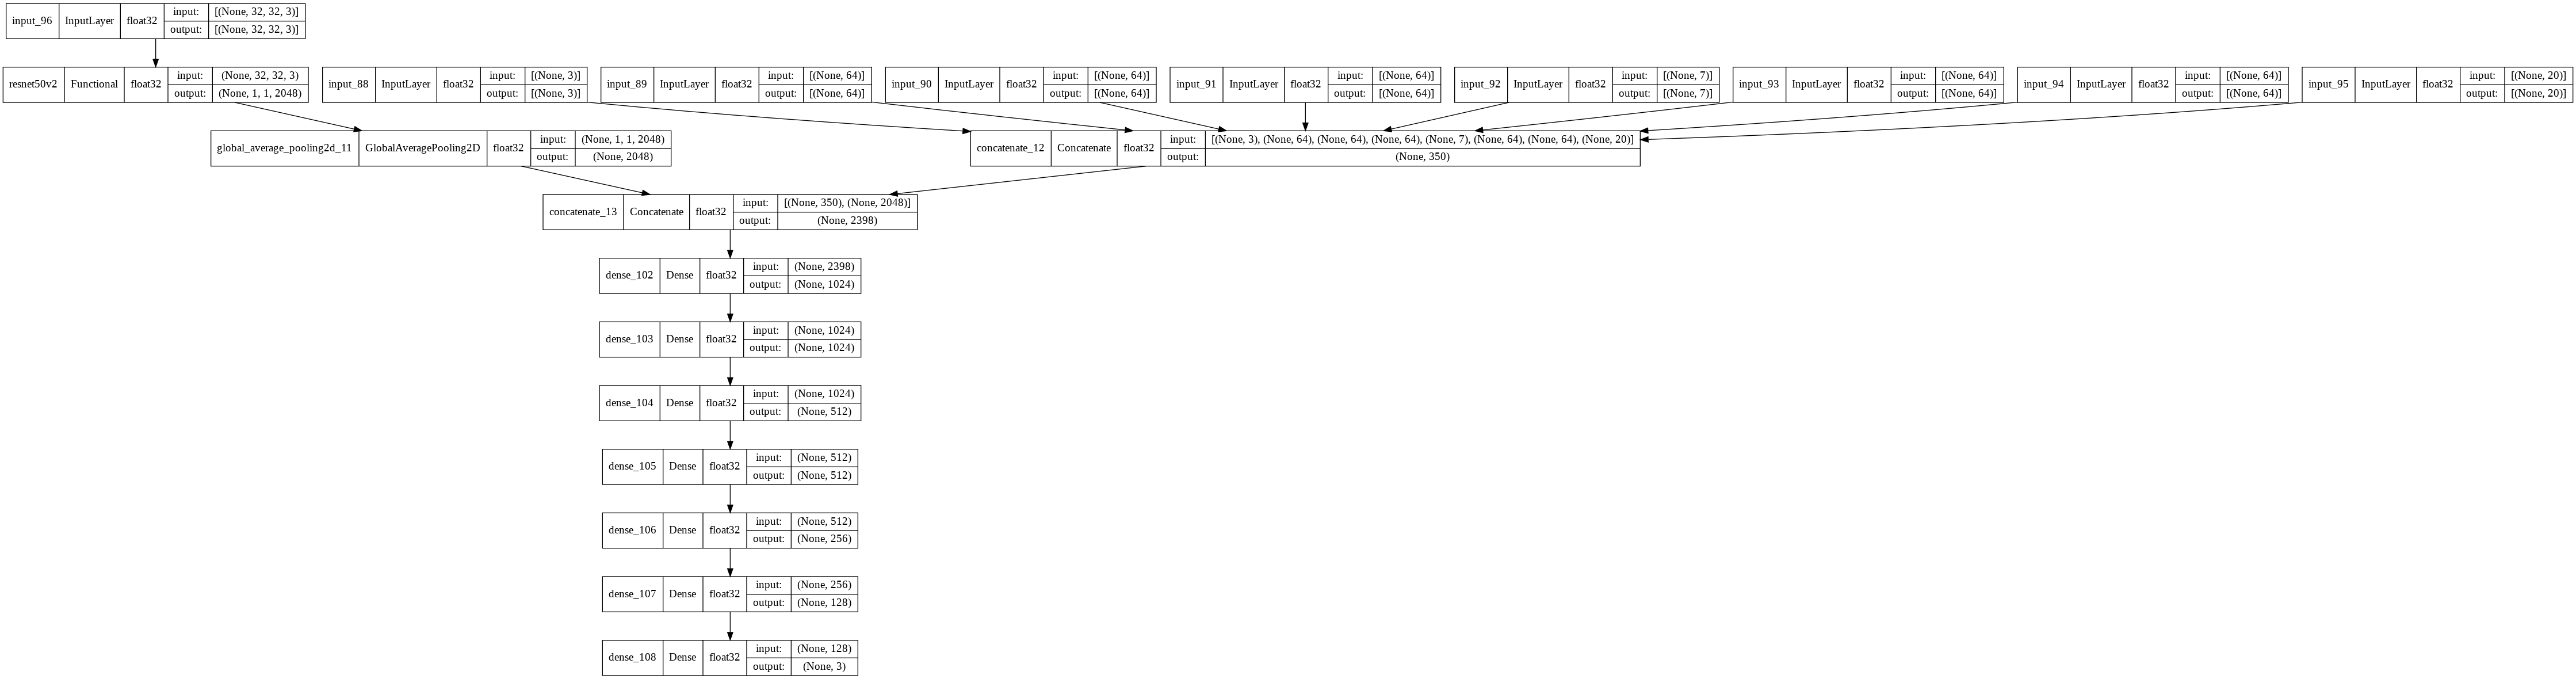

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
ResNet50V2WIDE_model, to_file='modelRES.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

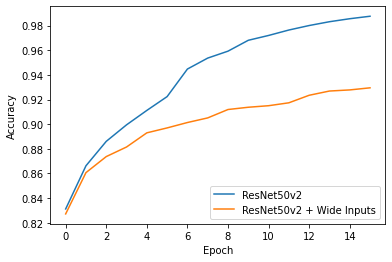

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

# ResNet50v2 1024 Param Deep Input + 350 Param Wide Input

In [ ]:
ResNet50V2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = ResNet50V2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)

merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

ResNet50V2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

ResNet50V2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_ResNet50V2WIDE_1024 = ResNet50V2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
450/450 [==============================] - 160s 354ms/step - loss: 0.3846 - accuracy: 0.8314 - val_loss: 0.3395 - val_accuracy: 0.8521
Epoch 2/16
450/450 [==============================] - 123s 274ms/step - loss: 0.2941 - accuracy: 0.8705 - val_loss: 0.3060 - val_accuracy: 0.8757
Epoch 3/16
450/450 [==============================] - 114s 254ms/step - loss: 0.2465 - accuracy: 0.8942 - val_loss: 0.3081 - val_accuracy: 0.8703
Epoch 4/16
450/450 [==============================] - 105s 234ms/step - loss: 0.2157 - accuracy: 0.9081 - val_loss: 0.3135 - val_accuracy: 0.8881
Epoch 5/16
450/450 [==============================] - 106s 237ms/step - loss: 0.1850 - accuracy: 0.9236 - val_loss: 0.3381 - val_accuracy: 0.8804
Epoch 6/16
450/450 [==============================] - 105s 233ms/step - loss: 0.1718 - accuracy: 0.9275 - val_loss: 0.3470 - val_accuracy: 0.8904
Epoch 7/16
450/450 [==============================] - 105s 234ms/step - loss: 0.1502 - accuracy: 0.9380 - val_loss: 0.4115 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
history_ResNet50V2WIDE_1024, to_file='history_ResNet50V2WIDE_1024.png', show_shapes=True, show_dtype=True,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

AttributeError: ignored

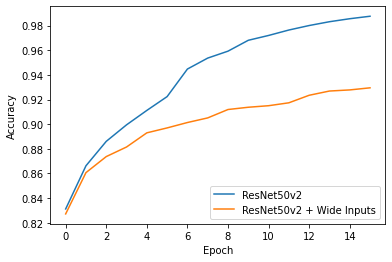

In [ ]:
plt.plot(history_ResNet50V2.history['accuracy'])
plt.plot(history_ResNet50V2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet50v2', 'ResNet50v2 + Wide Inputs'], loc='lower right')
plt.savefig('ResNethistory_mean.png', dpi=600)  
plt.savefig('ResNethistory_mean.pdf')

# DenseNet121 Tests:
20 Epochs:

  Wide And Deep:
*    1024 Param Deep Input + 350 Param Wide Input : .9911 Accuracy Max
*    512 Param Deep Input + 350 Param Wide Input  : Testing
*    256 Param Deep Input + 350 Param Wide Input  : Testing...

Deep Only:
*     1024 Param Deep Input: .9927 Accuracy Max



# DenseNet121 1024Param Deep Input + 350 Param Wide Input

Deep Performance is 0.5% (+- 0.05) is better than Wide&Deep Solution.

In [ ]:

from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
#x = layers.Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

DenseNet121_model = Model(inputs = inputs, outputs = predictions)

DenseNet121_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
DenseNet121_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_48 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_49 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_50 (Dense)            (None, 512)               524800    
                                                           

In [ ]:
history_DenseNet121 = DenseNet121_model.fit( x_train,y_train,
                                               validation_data=(x_test,y_test),
                                               epochs=20,
                                               batch_size = batch_size
                                               #callbacks=[reduce_lr]
                                              )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 196s 436ms/step - loss: 0.2498 - accuracy: 0.8982 - val_loss: 0.1601 - val_accuracy: 0.9386
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1720 - accuracy: 0.9320 - val_loss: 0.1465 - val_accuracy: 0.9444
Epoch 3/20
450/450 [==============================] - 167s 370ms/step - loss: 0.1386 - accuracy: 0.9453 - val_loss: 0.1742 - val_accuracy: 0.9408
Epoch 4/20
450/450 [==============================] - 166s 368ms/step - loss: 0.1201 - accuracy: 0.9549 - val_loss: 0.1400 - val_accuracy: 0.9514
Epoch 5/20
450/450 [==============================] - 166s 368ms/step - loss: 0.1004 - accuracy: 0.9616 - val_loss: 0.1375 - val_accuracy: 0.9478
Epoch 6/20
450/450 [==============================] - 166s 369ms/step - loss: 0.0956 - accuracy: 0.9667 - val_loss: 0.1510 - val_accuracy: 0.9513
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0750 - accuracy: 0.9713 - val_loss: 0.1437 -

In [ ]:
DenseNet121WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                              wideInputInvariantRed,
                                              wideInputInvariantGreen,
                                              wideInputInvariantBlue, 
                                              wideInputHU,
                                              wideInputHOG,
                                              wideInputLPB,
                                              wideInputGLCM
                                              ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

DenseNet121WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

DenseNet121WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE = DenseNet121WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 20,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 169s 376ms/step - loss: 0.2521 - accuracy: 0.8953 - val_loss: 0.2232 - val_accuracy: 0.9094
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.1576 - val_accuracy: 0.9371
Epoch 3/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 5/20
450/450 [==============================] - 166s 369ms/step - loss: 0.1113 - accuracy: 0.9576 - val_loss: 0.1543 - val_accuracy: 0.9465
Epoch 6/20
450/450 [==============================] - 167s 371ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0933 - accuracy: 0.9633 - val_loss: 0.1418 -

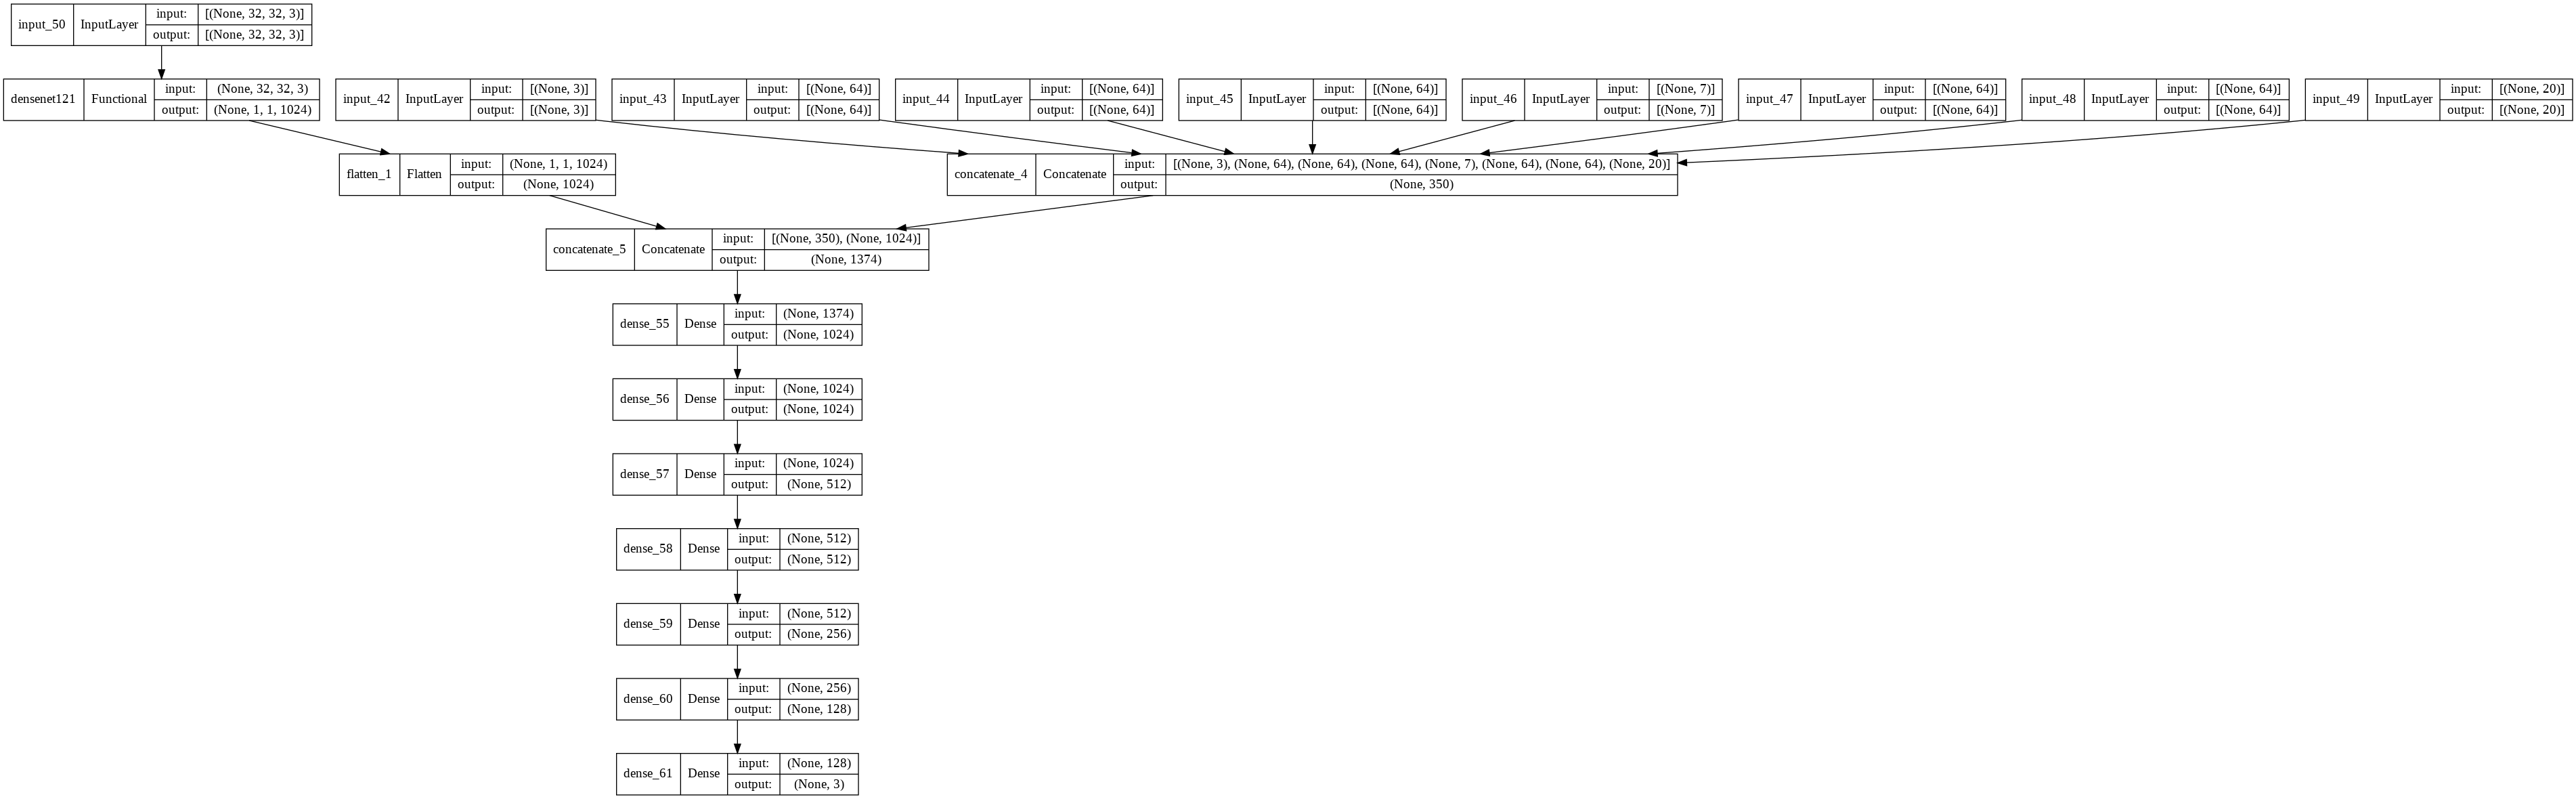

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_model, to_file='modeleff.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

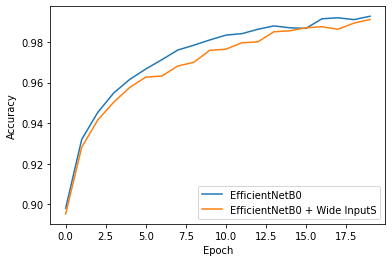

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['EfficientNetB0', 'EfficientNetB0 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# DenseNet121 512Param Deep Input + 350 Param Wide Input


In [ ]:
DenseNet121WIDE_512_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = DenseNet121(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([ wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                  ])

merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])
# Dense Layers, Feature Selection
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

DenseNet121WIDE_512_model = tf.keras.Model( inputs=[wideInput0, 
                                            wideInputInvariantRed,
                                            wideInputInvariantGreen,
                                            wideInputInvariantBlue, 
                                            wideInputHU,
                                            wideInputHOG,
                                            wideInputLPB,
                                            wideInputGLCM, 
                                            wideInputD
                                            ],  
                                            outputs=merged_out)

DenseNet121WIDE_512_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_DenseNet121WIDE_512 = DenseNet121WIDE_512_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 20,
                                            batch_size = batch_size,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
450/450 [==============================] - 169s 376ms/step - loss: 0.2521 - accuracy: 0.8953 - val_loss: 0.2232 - val_accuracy: 0.9094
Epoch 2/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.1576 - val_accuracy: 0.9371
Epoch 3/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1498 - accuracy: 0.9416 - val_loss: 0.1470 - val_accuracy: 0.9454
Epoch 4/20
450/450 [==============================] - 168s 373ms/step - loss: 0.1276 - accuracy: 0.9504 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 5/20
450/450 [==============================] - 166s 369ms/step - loss: 0.1113 - accuracy: 0.9576 - val_loss: 0.1543 - val_accuracy: 0.9465
Epoch 6/20
450/450 [==============================] - 167s 371ms/step - loss: 0.0960 - accuracy: 0.9627 - val_loss: 0.1372 - val_accuracy: 0.9525
Epoch 7/20
450/450 [==============================] - 166s 368ms/step - loss: 0.0933 - accuracy: 0.9633 - val_loss: 0.1418 -

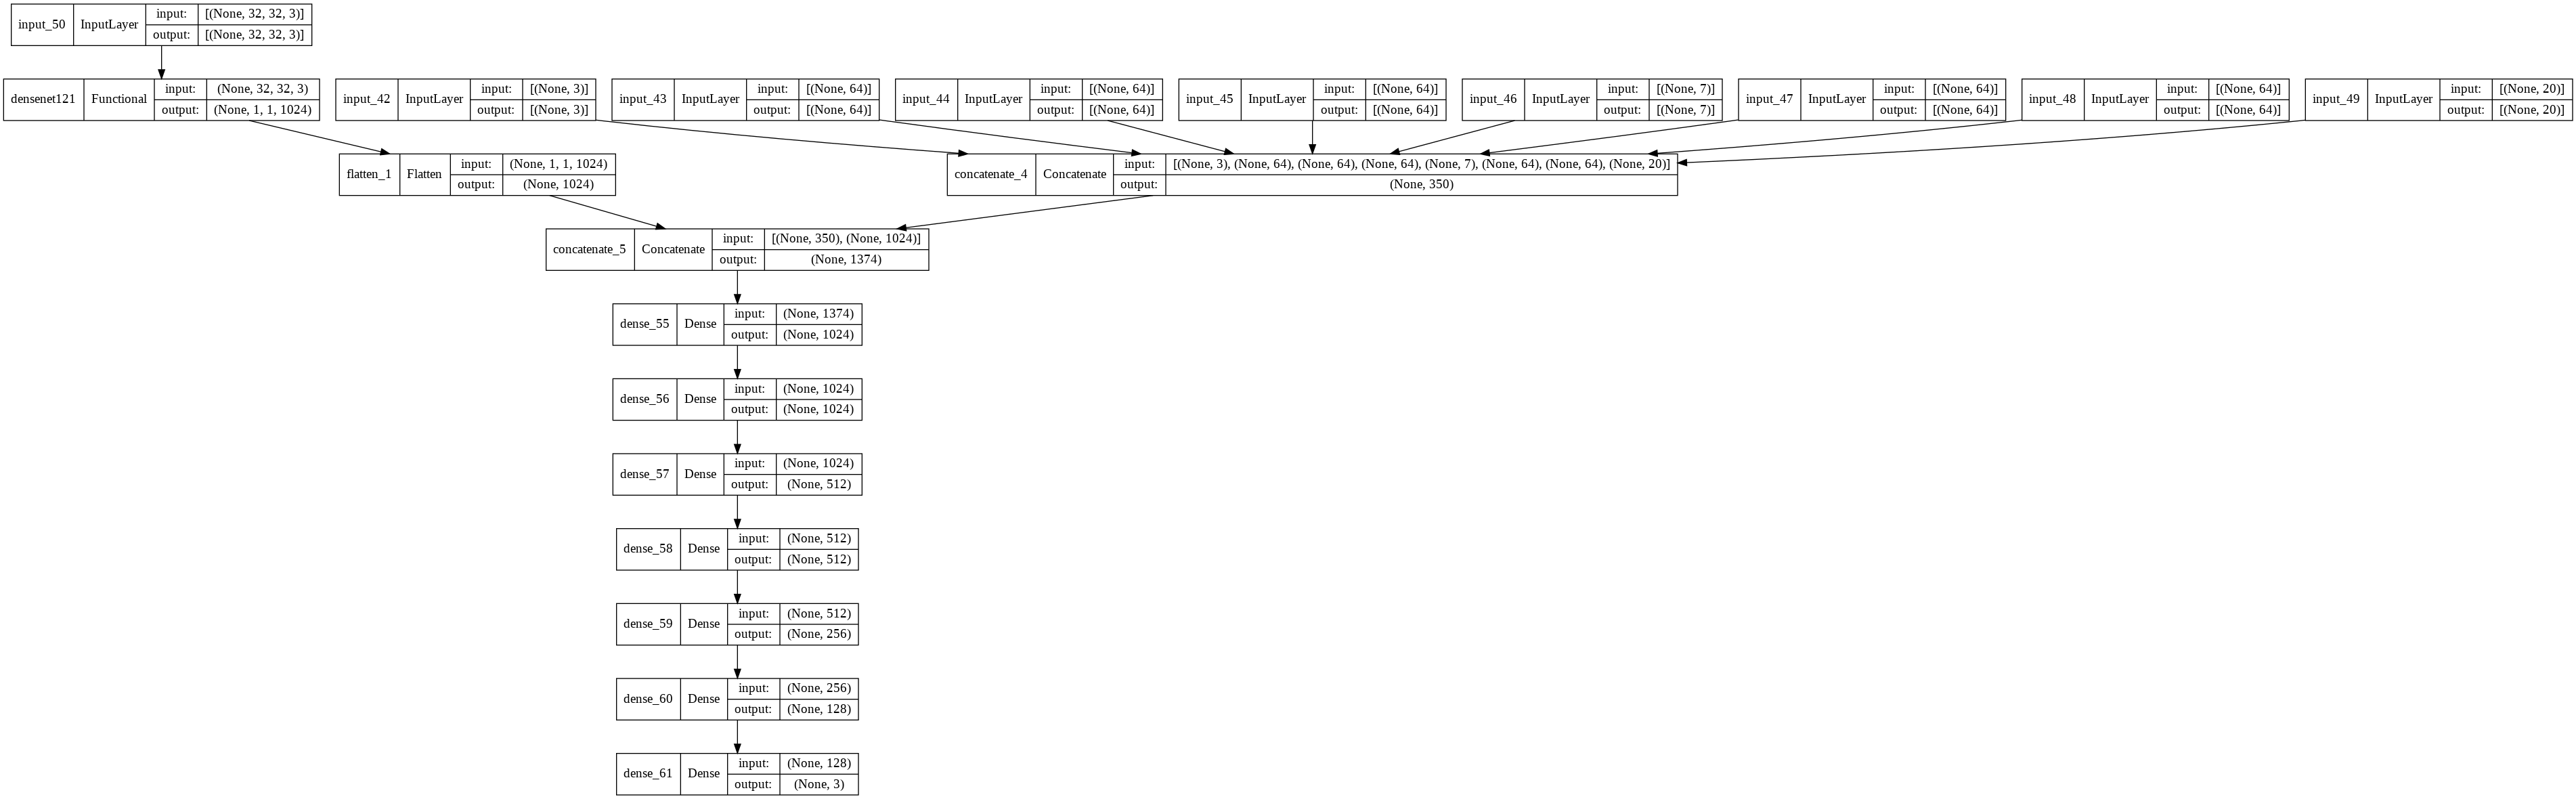

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
DenseNet121WIDE_512_model, to_file='DenseNet121WIDE_512_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

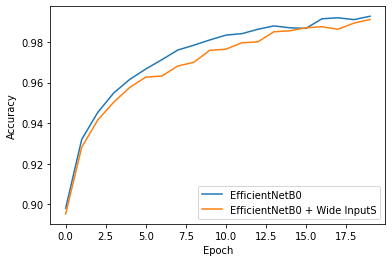

In [ ]:
plt.plot(history_DenseNet121.history['accuracy'])
plt.plot(history_DenseNet121WIDE_512.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['DenseNet121', 'DenseNet121 + Wide InputS'], loc='lower right')
plt.savefig('aLLhistory.png', dpi=300)  
plt.savefig('aLLhistory.pdf')

# MobileNetV2 Tests:
16 Epochs:

  Wide And Deep:
*    1024 Param Deep Input + 350 Param Wide Input : .9344 Accuracy Max
*    512 Param Deep Input + 350 Param Wide Input  : .9294 Accuracy Max
*    256 Param Deep Input + 350 Param Wide Input  : .9216 Accuracy Max

Deep Only:
*     1280 Param Deep Input: .9050 Accuracy Max



# **MobileNetV2 Tests:**

## MobileNetv2 512 Param Deep Input + 350 Param Wide Input

Wide&Deep Performance is 2% (+- 0.05) is better than Deep Solution only.

In [ ]:

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
#x = layers.Flatten()(x)
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

MobileNetV2_model = Model(inputs = inputs, outputs = predictions)

MobileNetV2_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
MobileNetV2_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                

In [ ]:
history_MobileNetV2 = MobileNetV2_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=epochs,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
201/900 [=====>........................] - ETA: 4:50 - loss: 0.1863 - accuracy: 0.9206

KeyboardInterrupt: ignored

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_20[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 456s 507ms/step - loss: 0.4277 - accuracy: 0.8041 - val_loss: 0.3638 - val_accuracy: 0.8364
Epoch 2/16
900/900 [==============================] - 419s 465ms/step - loss: 0.3638 - accuracy: 0.8380 - val_loss: 0.3426 - val_accuracy: 0.8512
Epoch 3/16
900/900 [==============================] - 412s 458ms/step - loss: 0.3201 - accuracy: 0.8589 - val_loss: 0.3243 - val_accuracy: 0.8672
Epoch 4/16
900/900 [==============================] - 414s 460ms/step - loss: 0.2949 - accuracy: 0.8743 - val_loss: 0.2996 - val_accuracy: 0.8774
Epoch 5/16
900/900 [==============================] - 414s 460ms/step - loss: 0.2808 - accuracy: 0.8800 - val_loss: 0.3796 - val_accuracy: 0.8469
Epoch 6/16
900/900 [==============================] - 403s 447ms/step - loss: 0.2660 - accuracy: 0.8869 - val_loss: 0.3138 - val_accuracy: 0.8639
Epoch 7/16
900/900 [==============================] - 403s 448ms/step - loss: 0.2576 - accuracy: 0.8895 - val_loss: 0.3799 -

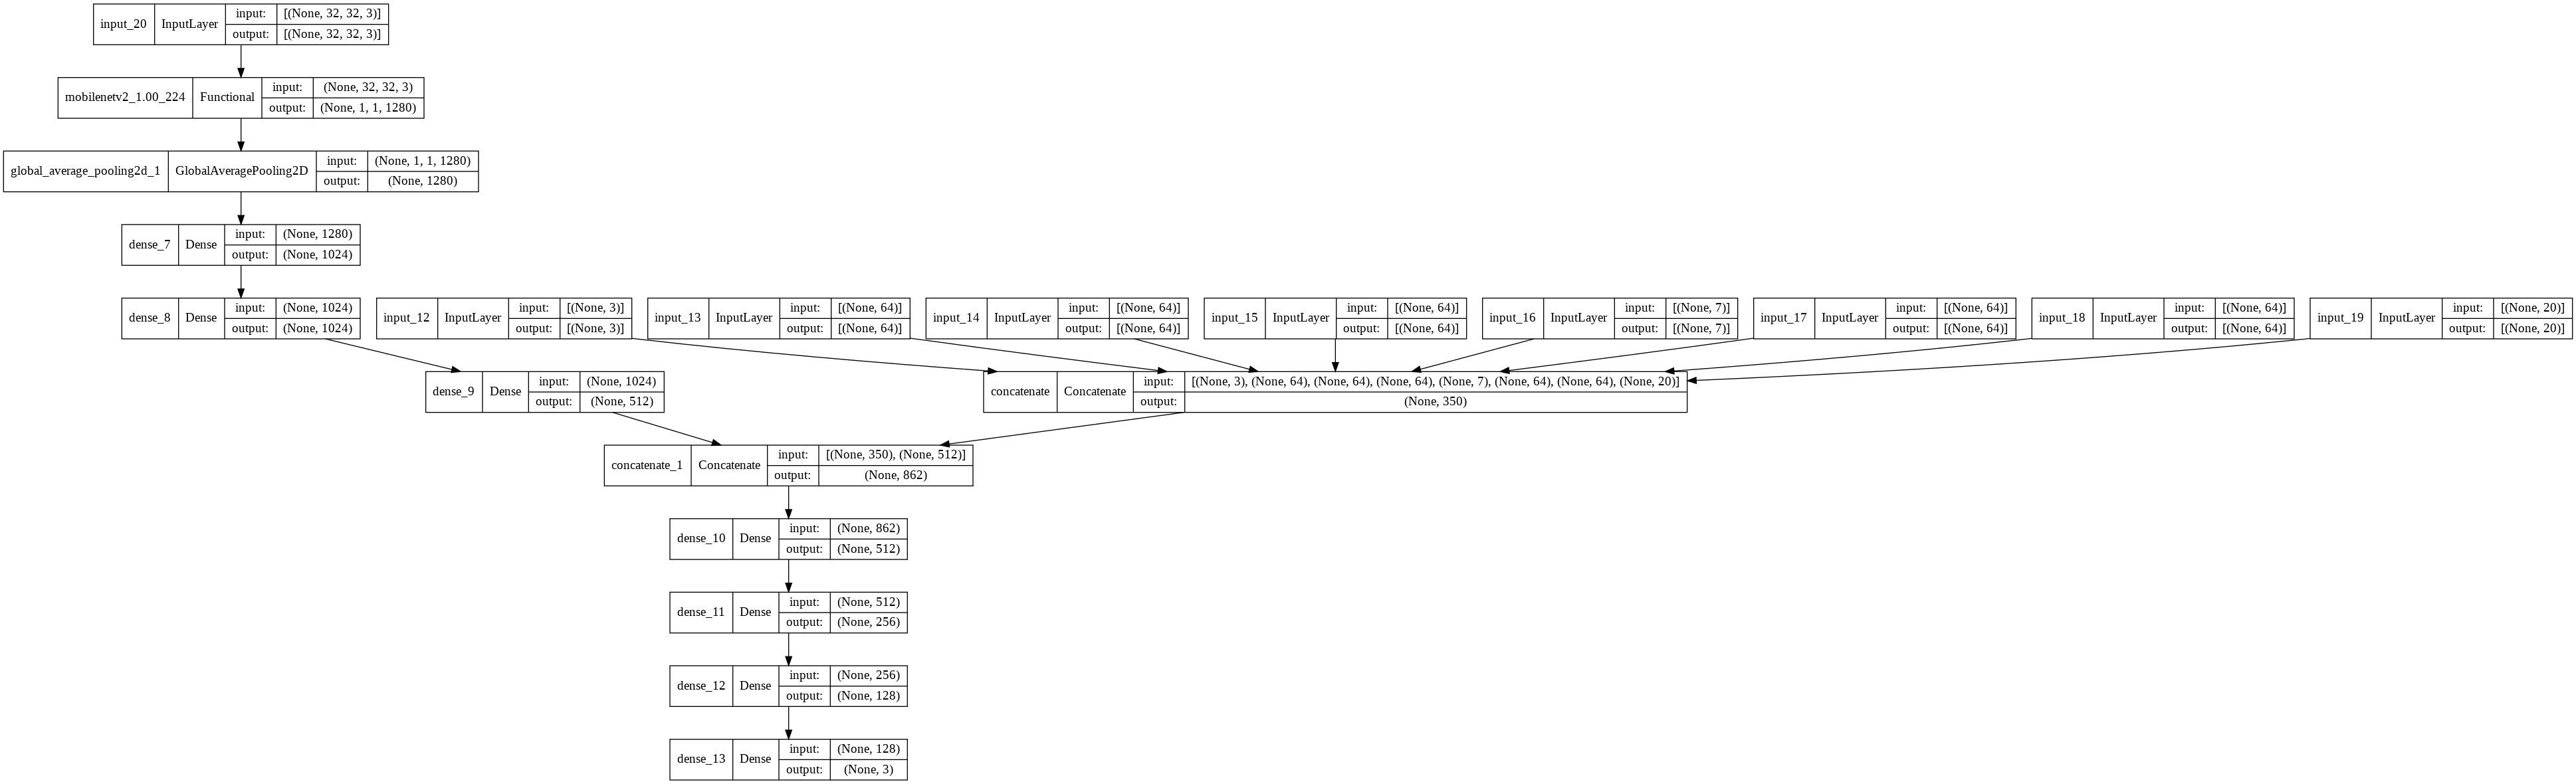

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

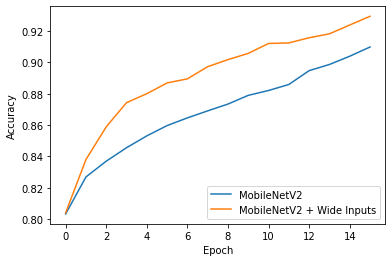

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_78 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

## MobileNetv2 1024 Param Deep Input + 350 Param Wide Input
Wide&Deep Performance is 3.5% (+- 0.05) is better than MobileNetv2 1024 Param Deep Input + 350 Param Wide Input solution.

In [ ]:
MobileNetV2WIDE_1024_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
#merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

MobileNetV2WIDE_1024_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_1024_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_1024_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_20[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_1024 = MobileNetV2WIDE_1024_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 464s 515ms/step - loss: 0.4288 - accuracy: 0.8056 - val_loss: 0.3806 - val_accuracy: 0.8239
Epoch 2/16
900/900 [==============================] - 473s 525ms/step - loss: 0.3686 - accuracy: 0.8347 - val_loss: 0.3632 - val_accuracy: 0.8357
Epoch 3/16
900/900 [==============================] - 466s 518ms/step - loss: 0.3185 - accuracy: 0.8598 - val_loss: 0.3215 - val_accuracy: 0.8603
Epoch 4/16
900/900 [==============================] - 477s 530ms/step - loss: 0.2946 - accuracy: 0.8743 - val_loss: 0.3101 - val_accuracy: 0.8682
Epoch 5/16
900/900 [==============================] - 493s 547ms/step - loss: 0.2721 - accuracy: 0.8835 - val_loss: 0.3199 - val_accuracy: 0.8590
Epoch 6/16
900/900 [==============================] - 478s 531ms/step - loss: 0.2632 - accuracy: 0.8881 - val_loss: 0.3023 - val_accuracy: 0.8681
Epoch 7/16
900/900 [==============================] - 482s 535ms/step - loss: 0.2486 - accuracy: 0.8943 - val_loss: 0.2883 -

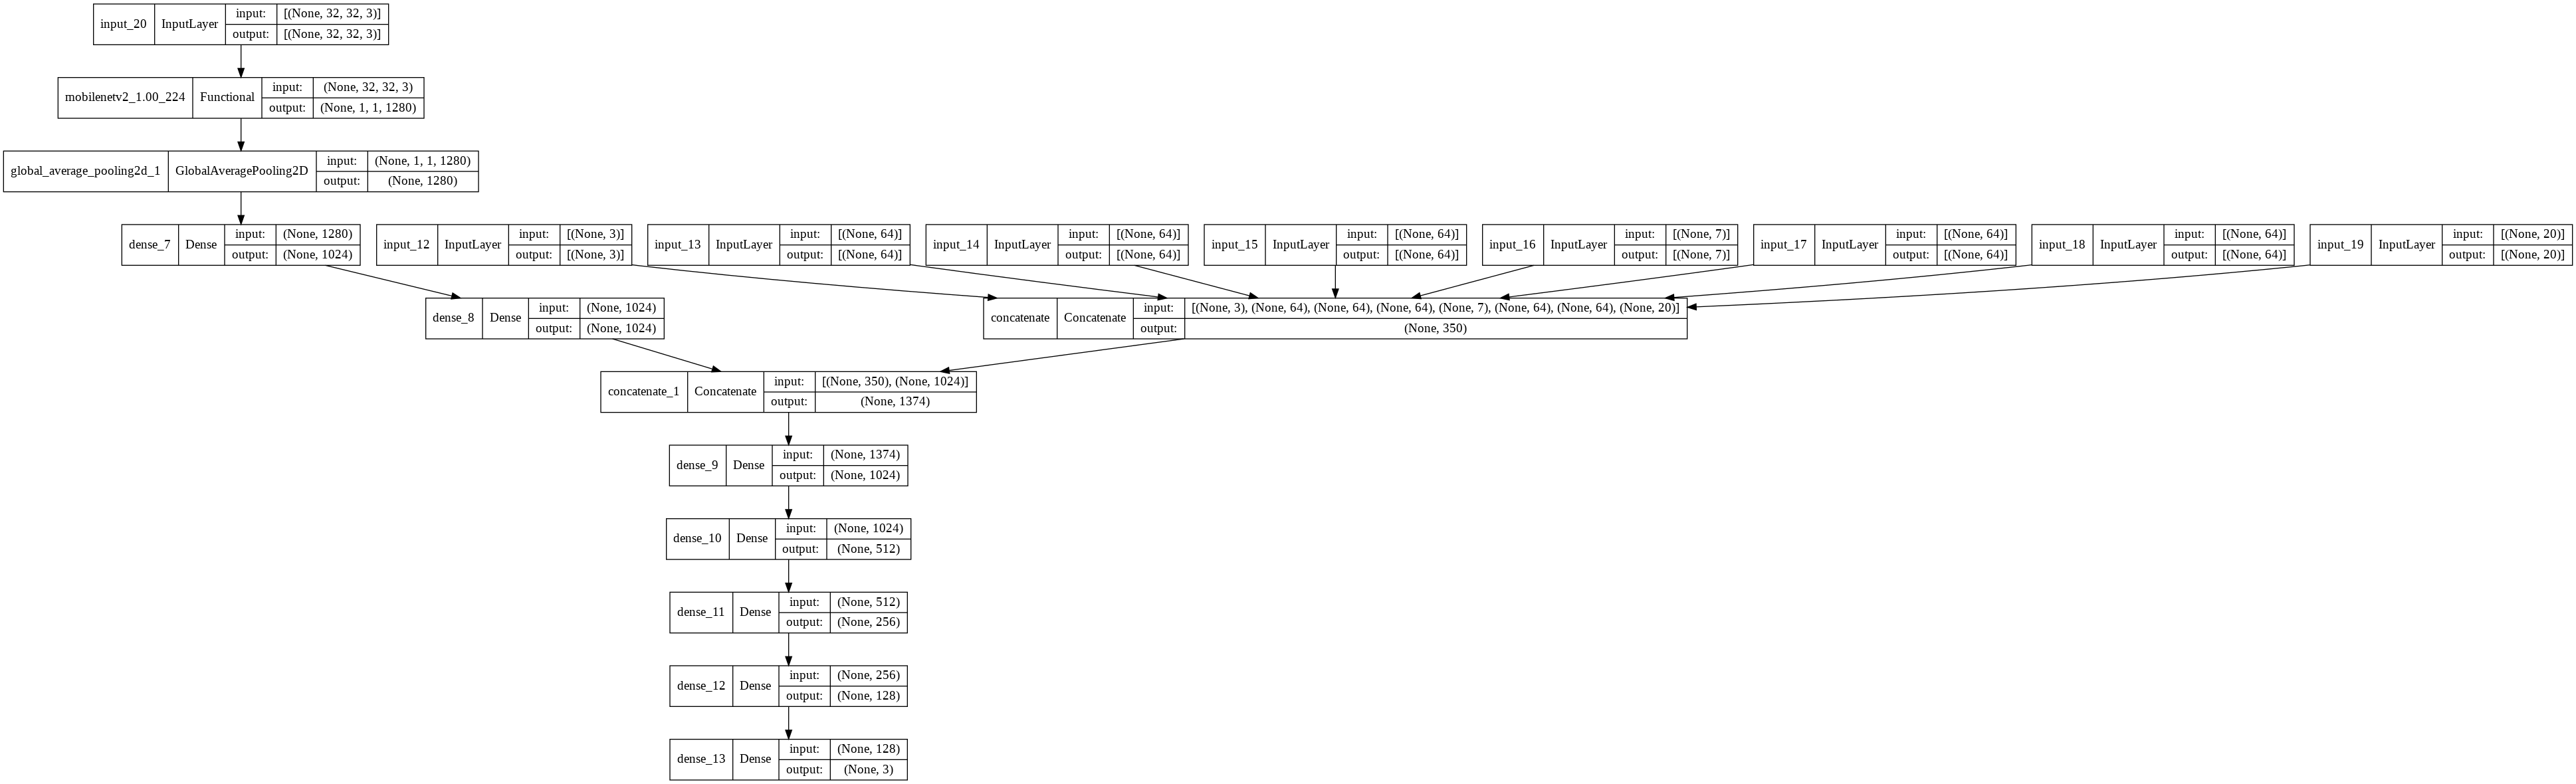

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

NameError: ignored

## MobileNetv2 256 Param Deep Input + 350 Param Wide Input
Wide&Deep Performance is 0.5% (+- 0.05) is worse than MobileNetv2 512 Param Deep Input + 350 Param Wide Input solution.

In [ ]:
MobileNetV2WIDE_256_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_deep = layers.Dense(units=256, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

MobileNetV2WIDE_256_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_256_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_256_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_50 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_50[0][0]']               
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_4 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                            
                                                                                            

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_256 = MobileNetV2WIDE_256_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 201s 223ms/step - loss: 0.4215 - accuracy: 0.8066 - val_loss: 0.3801 - val_accuracy: 0.8299
Epoch 2/16
900/900 [==============================] - 191s 212ms/step - loss: 0.3609 - accuracy: 0.8382 - val_loss: 0.4599 - val_accuracy: 0.7732
Epoch 3/16
900/900 [==============================] - 172s 192ms/step - loss: 0.3240 - accuracy: 0.8587 - val_loss: 0.3268 - val_accuracy: 0.8604
Epoch 4/16
900/900 [==============================] - 192s 214ms/step - loss: 0.2977 - accuracy: 0.8722 - val_loss: 0.3260 - val_accuracy: 0.8549
Epoch 5/16
900/900 [==============================] - 191s 213ms/step - loss: 0.2829 - accuracy: 0.8775 - val_loss: 0.3570 - val_accuracy: 0.8597
Epoch 6/16
900/900 [==============================] - 191s 212ms/step - loss: 0.2658 - accuracy: 0.8860 - val_loss: 0.3524 - val_accuracy: 0.8710
Epoch 7/16
900/900 [==============================] - 191s 213ms/step - loss: 0.2551 - accuracy: 0.8910 - val_loss: 0.3429 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

## MobileNetv2 1280 Param Deep Input + 350 Param Wide Input
Wide&Deep Performance is xxxx is better than MobileNetv2 1280 Param Deep Input + 350 Param Wide Input solution.

In [ ]:
MobileNetV2WIDE_1280_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
#aug = layers.experimental.preprocessing.RandomFlip("horizontal")(wideInputD)
#aug = layers.experimental.preprocessing.RandomRotation(0.15)(aug)
#aug = layers.experimental.preprocessing.RandomContrast(0.2)(aug)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1280, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1280, activation='relu')(merged_deep)
# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
#merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

MobileNetV2WIDE_1280_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_1280_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

history_MobileNetV2WIDE_1280 = MobileNetV2WIDE_1280_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = epochs,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/16
900/900 [==============================] - 236s 262ms/step - loss: 0.4347 - accuracy: 0.8012 - val_loss: 0.4463 - val_accuracy: 0.8012
Epoch 2/16
900/900 [==============================] - 175s 194ms/step - loss: 0.3700 - accuracy: 0.8345 - val_loss: 0.3585 - val_accuracy: 0.8410
Epoch 3/16
900/900 [==============================] - 173s 192ms/step - loss: 0.3245 - accuracy: 0.8591 - val_loss: 0.3080 - val_accuracy: 0.8676
Epoch 4/16
900/900 [==============================] - 172s 191ms/step - loss: 0.2995 - accuracy: 0.8718 - val_loss: 0.3204 - val_accuracy: 0.8719
Epoch 5/16
900/900 [==============================] - 193s 214ms/step - loss: 0.2930 - accuracy: 0.8763 - val_loss: 0.3411 - val_accuracy: 0.8767
Epoch 6/16
900/900 [==============================] - 171s 190ms/step - loss: 0.2689 - accuracy: 0.8860 - val_loss: 0.3122 - val_accuracy: 0.8757
Epoch 7/16
900/900 [==============================] - 191s 212ms/step - loss: 0.2524 - accuracy: 0.8918 - val_loss: 0.4414 -

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_1024_model, to_file='MobileNetV2WIDE_1024_model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

NameError: ignored

In [ ]:
plt.plot(history_MobileNetV2.history['accuracy'])
plt.plot(history_MobileNetV2WIDE_1024.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=300)  
plt.savefig('MobileNetV2.pdf')

# **MobileNetV2 2nd Experiment**

## MobileNetV2 2nd Experiment

Wide&Deep Performance is 3.7% (+- 0.05) is better than Deep Solution only.

In [ ]:

from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False

inputs = tf.keras.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
#x = layers.Flatten()(x)
x = GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dropout(0.2)(x)
#x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
#x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(128,activation='relu')(x)
predictions = Dense(3, activation= 'softmax')(x)

xx_model = Model(inputs = inputs, outputs = predictions)

xx_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
xx_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                

In [ ]:
history_xx_model = xx_model.fit(x_train,y_train,
                                            validation_data=(x_test,y_test),
                                            epochs=24,
                                            #callbacks=[reduce_lr]
                                            )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/24
900/900 [==============================] - 148s 165ms/step - loss: 0.4259 - accuracy: 0.8065 - val_loss: 0.3874 - val_accuracy: 0.8235
Epoch 2/24
900/900 [==============================] - 153s 170ms/step - loss: 0.3814 - accuracy: 0.8264 - val_loss: 0.3838 - val_accuracy: 0.8274
Epoch 3/24
900/900 [==============================] - 152s 169ms/step - loss: 0.3625 - accuracy: 0.8362 - val_loss: 0.3729 - val_accuracy: 0.8379
Epoch 4/24
900/900 [==============================] - 148s 165ms/step - loss: 0.3492 - accuracy: 0.8408 - val_loss: 0.3623 - val_accuracy: 0.8414
Epoch 5/24
900/900 [==============================] - 149s 166ms/step - loss: 0.3368 - accuracy: 0.8464 - val_loss: 0.3559 - val_accuracy: 0.8407
Epoch 6/24
900/900 [==============================] - 152s 169ms/step - loss: 0.3304 - accuracy: 0.8526 - val_loss: 0.3550 - val_accuracy: 0.8421
Epoch 7/24
900/900 [==============================] - 152s 169ms/step - loss: 0.3194 - accuracy: 0.8590 - val_loss: 0.3684 -

In [ ]:
MobileNetV2WIDE_model = tf.keras.Sequential()                              
#Wide Inputs
wideInput0 = layers.Input(shape=(3,))
wideInputInvariantRed = layers.Input(shape=(64,))
wideInputInvariantGreen = layers.Input(shape=(64,))
wideInputInvariantBlue = layers.Input(shape=(64,))
wideInputHU = layers.Input(shape=(7,))
wideInputHOG = layers.Input(shape=(64,))
wideInputLPB = layers.Input(shape=(64,))
wideInputGLCM = layers.Input(shape=(20,))

#Deep Input(s)
wideInputD = layers.Input(shape=(input_shape))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
base_model = MobileNetV2(weights= 'imagenet', include_top=False, input_shape= (input_shape))
base_model.trainable = False
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
merged_deep = base_model(wideInputD, training=False)
#merged_deep = layers.Flatten()(merged_deep)
merged_deep = GlobalAveragePooling2D()(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=1024, activation='relu')(merged_deep)
merged_deep = layers.Dense(units=512, activation='relu')(merged_deep)

# Concatenate Wide + Deep Inputs
merged_wide = tf.keras.layers.Concatenate(axis=1)([wideInput0,
                                                    wideInputInvariantRed,
                                                    wideInputInvariantGreen,
                                                    wideInputInvariantBlue, 
                                                    wideInputHU,
                                                    wideInputHOG,
                                                    wideInputLPB,
                                                    wideInputGLCM
                                                    ])
merged_out = layers.Concatenate(axis=1)([merged_wide, merged_deep])

# Dense Layers, Feature Selection
#merged_out = layers.GlobalAveragePooling2D()(merged_combined)
#merged_out = layers.Dense(units=1024, activation='relu')(merged_combined)
merged_out = layers.Dense(units=1024, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=512, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=256, activation='relu')(merged_out)
merged_out = layers.Dropout(0.2)(merged_out)
merged_out = layers.Dense(units=128, activation='relu')(merged_out)
merged_out = layers.Dense(units=3, activation='softmax')(merged_out)

MobileNetV2WIDE_model = tf.keras.Model(inputs=[wideInput0, 
                                     wideInputInvariantRed,
                                     wideInputInvariantGreen,
                                     wideInputInvariantBlue, 
                                     wideInputHU,
                                     wideInputHOG,
                                     wideInputLPB,
                                     wideInputGLCM, 
                                     wideInputD
                                     ],  
                             outputs=merged_out)

MobileNetV2WIDE_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_165 (InputLayer)         [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 1, 1, 1280)  2257984     ['input_165[0][0]']              
 al)                                                                                              
                                                                                                  
 global_average_pooling2d_10 (G  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 lobalAveragePooling2D)                                                                           
                                                                                           

In [ ]:
GLCMdata_trainMerged = [x_train_mean ,
                        x_train_invariant_Red,
                        x_train_invariant_Green,
                        x_train_invariant_Blue,
                        x_train_HU,
                        x_train_hog_vector,
                        x_train_lbp_vector,
                        x_train_glcm, 
                        x_train
                        ]

GLCMdata_valMerged = [x_test_mean,
                      x_test_invariant_Red, 
                      x_test_invariant_Green,
                      x_test_invariant_Blue,
                      x_test_HU,
                      x_test_hog_vector,
                      x_test_lbp_vector,
                      x_test_glcm,
                      x_test
                      ]

ALLhistory_exp2 = MobileNetV2WIDE_model.fit(GLCMdata_trainMerged, 
                                            y_train,
                                            epochs = 24,
                                            validation_data=(GLCMdata_valMerged, y_test),
                                            #callbacks = [reduce_lr]
                                            )
                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/24
900/900 [==============================] - 170s 189ms/step - loss: 0.4467 - accuracy: 0.7966 - val_loss: 0.3903 - val_accuracy: 0.8207
Epoch 2/24
900/900 [==============================] - 158s 176ms/step - loss: 0.3811 - accuracy: 0.8273 - val_loss: 0.3761 - val_accuracy: 0.8285
Epoch 3/24
900/900 [==============================] - 158s 175ms/step - loss: 0.3500 - accuracy: 0.8470 - val_loss: 0.3281 - val_accuracy: 0.8579
Epoch 4/24
900/900 [==============================] - 156s 174ms/step - loss: 0.3212 - accuracy: 0.8638 - val_loss: 0.3226 - val_accuracy: 0.8615
Epoch 5/24
900/900 [==============================] - 157s 175ms/step - loss: 0.2948 - accuracy: 0.8757 - val_loss: 0.3323 - val_accuracy: 0.8692
Epoch 6/24
900/900 [==============================] - 153s 170ms/step - loss: 0.2818 - accuracy: 0.8812 - val_loss: 0.4591 - val_accuracy: 0.8686
Epoch 7/24
900/900 [==============================] - 155s 172ms/step - loss: 0.2707 - accuracy: 0.8856 - val_loss: 0.3373 -

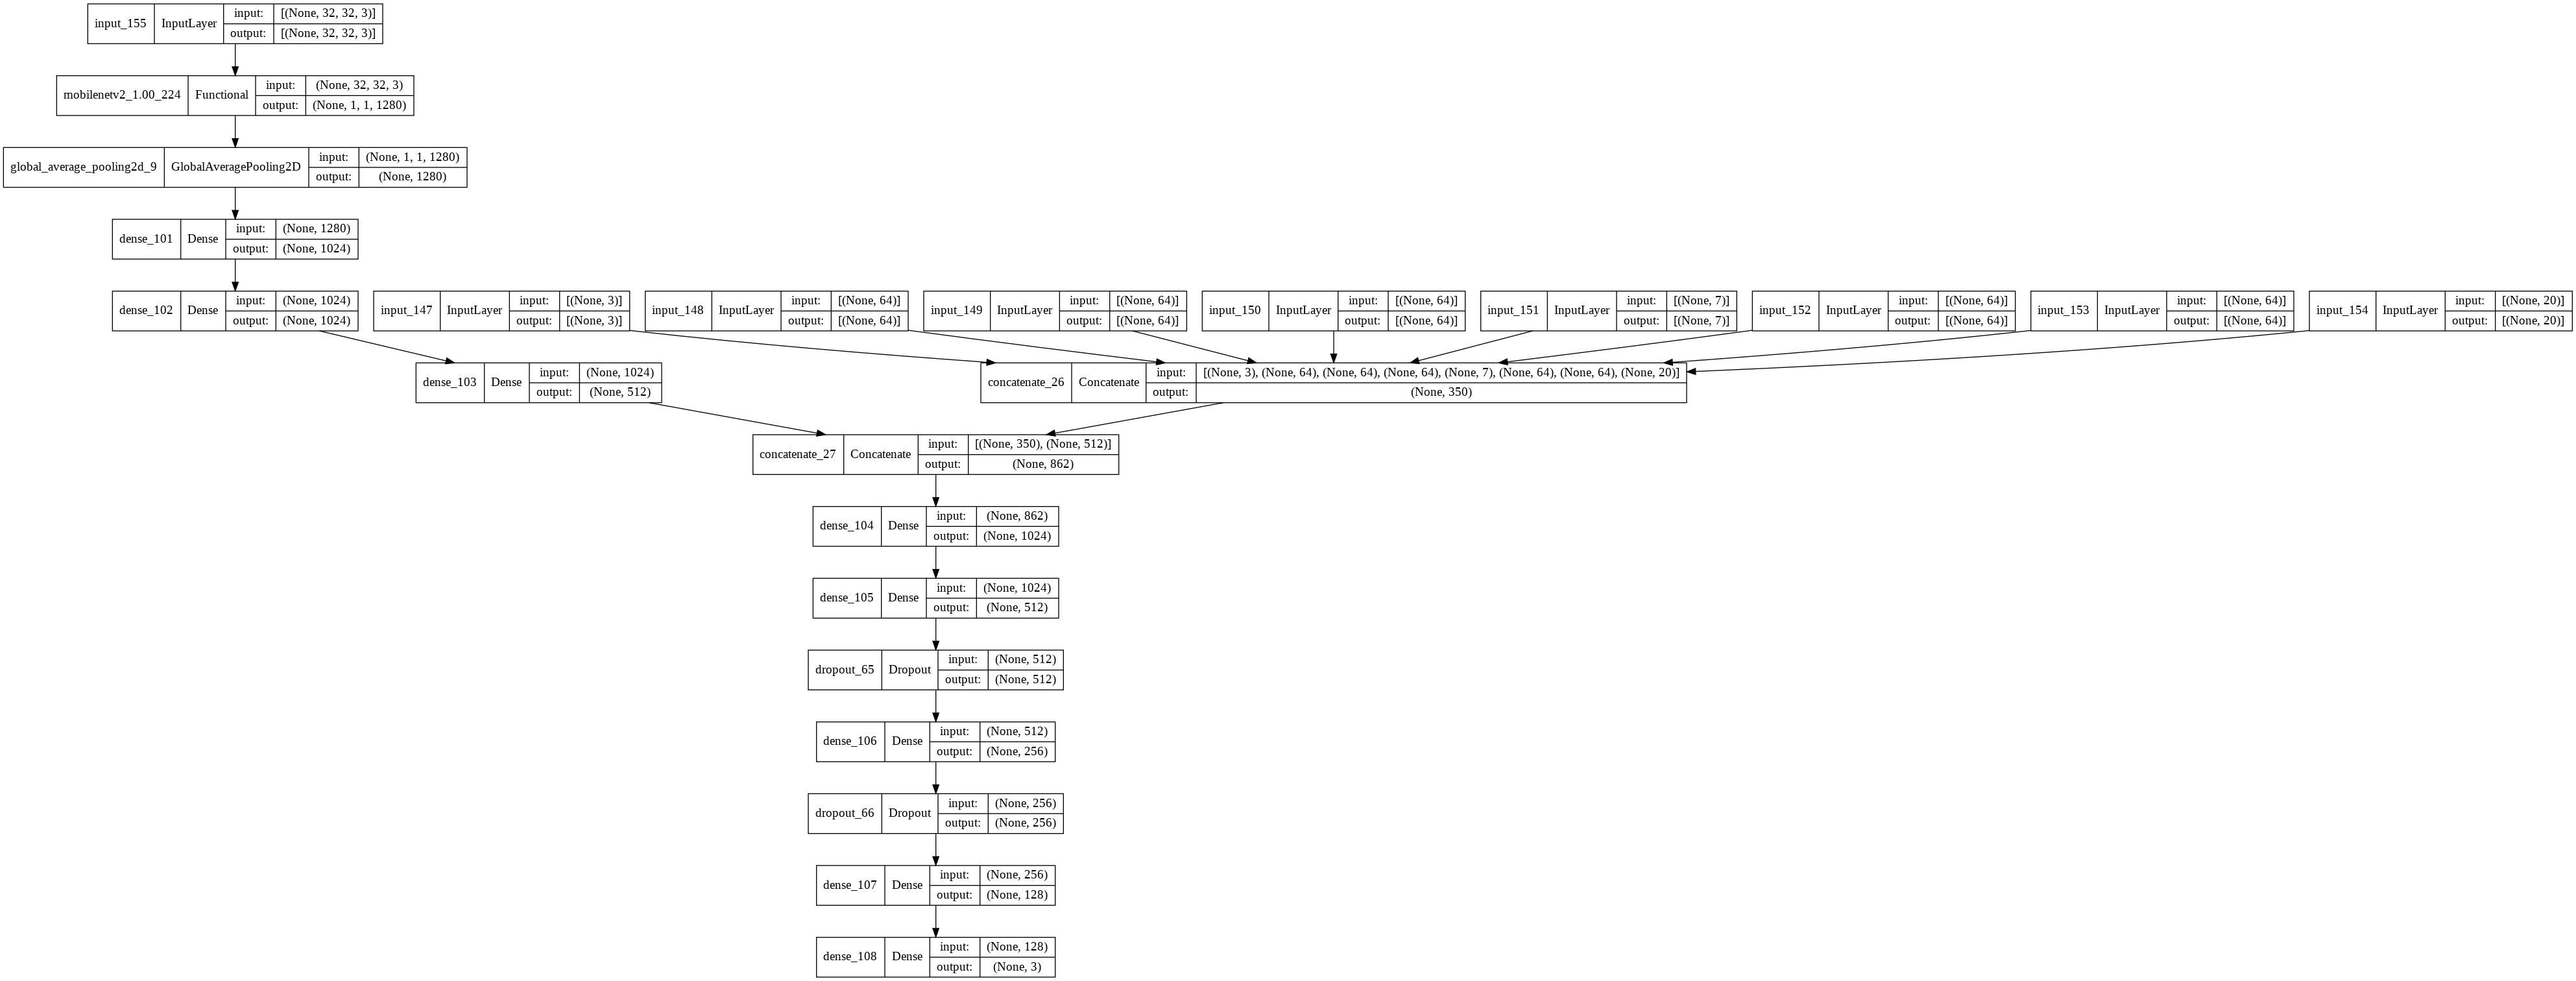

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
MobileNetV2WIDE_model, to_file='model.png', show_shapes=True, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

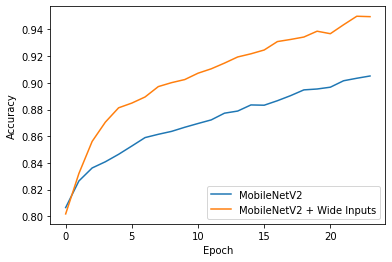

In [ ]:
plt.plot(history_xx_model.history['accuracy'])
plt.plot(ALLhistory_exp2.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MobileNetV2', 'MobileNetV2 + Wide Inputs'], loc='lower right')
plt.savefig('MobileNetV2.png', dpi=400)  
plt.savefig('MobileNetV2.pdf')

In [ ]:
MobileNetV2WIDE_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_74 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 input_75 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_78 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            